SwatGrains 2020 Data Analysis: BondInfo.txt file - Contact Networks and Force Distribution
==============

## 0.1. Load Data

Loads a set of bondInfo.txt files as hierarchically indexed DataFrames, which contain each jammed trial indexed by trial name and original row number. DataFrames are stored in the dictionary `dataDict`, and are indexed by abbreviated file names for easier iteration.
In order to identify which trials are jammed, a Pressures.txt file has to be generated for each data file via Info_Analysis.ipynb.

This cell also defines the `sort_particles()` function, which takes bond data and translates it into a DataFrame of particles identified by location and particle type.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os

def get_pressures(file):
    # the Pressures.txt file (created in Info_Analysis.ipynb) contains the seeds of all jammed trials, which we use to filter our data.
    # for some of our analysis, we'll also need pressures corresponding to each trial, which this file gives us.
    filePath=file.split('/')
    filePath[-1]=filePath[-1].replace('BondInfo','Pressures')
    trialPressures=pd.read_csv('/'.join(filePath), sep=' ', index_col=0)['pressure']
    if file[-8]=='6':
        trialPressures=trialPressures/4
    return trialPressures

def read_data(filename):
    dataset=pd.read_csv(filename, usecols=range(7), sep=' ', header=0, names=['x1','y1','x2','y2','energy','force','bondType']) # read bondInfo.txt
    dataset['trialName']=dataset.groupby((dataset.x1=='>>>>>').cumsum())['y1'].transform(lambda x: x.max()) # group by trial dividers, recognized by >>>>>, and label each row with group name
    dataset = dataset[dataset.x1 != '>>>>>'].reset_index(drop=True) # remove trial dividers

    # Generate higher level index
    dataset.index.rename('rowNumber', inplace=True)
    dataset.set_index('trialName',append=True,inplace=True)
    dataset.index=dataset.index.swaplevel()
    dataset=dataset.astype('float32') # convert all columns to float32 - 7 decimal places of precision is plenty
    dataset['bondType']=dataset['bondType'].astype('int16') # except bond type, which is a column of integers
    dataset['normalizedForce']=dataset.groupby('trialName')['force'].transform(lambda x: x/x.mean())
    dataset[['x1','y1','x2','y2','normalizedForce']]=(1e6*dataset[['x1','y1','x2','y2','normalizedForce']]).astype('int')
    return dataset.loc[get_pressures(filename).index]


def sort_particles(dataset, types=[0,1,2]):
    # same function as is used in cell 2.1 - sort particles into types via bondType column.
    # returns a dataframe of every coordinate in bondInfo - duplicates included.
    small_mobile=pd.DataFrame()
    large_mobile=pd.DataFrame()
    pins=pd.DataFrame()

    for bondGroup in dataset.groupby('bondType'):
        coords1=bondGroup[1][['x1','y1']].rename(columns={'x1':'x','y1':'y'})
        coords2=bondGroup[1][['x2','y2']].rename(columns={'x2':'x','y2':'y'})
        # case-by-case for each bond type
        if bondGroup[0]==0:
            # small-small
            small_mobile=pd.concat([small_mobile,coords1,coords2])

        if bondGroup[0]==1:
            # small-large
            small_mobile=pd.concat([small_mobile,coords1])
            large_mobile=pd.concat([large_mobile,coords2])

        if bondGroup[0]==2:
            # large-large
            large_mobile=pd.concat([large_mobile,coords1,coords2])

        if bondGroup[0]==3:
            # pin-small
            small_mobile=pd.concat([small_mobile,coords2])
            pins=pd.concat([pins,coords1])

        if bondGroup[0]==4:
            # pin-large
            large_mobile=pd.concat([large_mobile,coords2])
            pins=pd.concat([pins,coords1])
    # Cut off coordinate values at six decimals - this accounts for issues with floating point arithmetic
    large_mobile=large_mobile.round(6)
    small_mobile=small_mobile.round(6)
    pins=pins.round(6)

    sortedFrame=pd.concat([large_mobile.assign(particleType=2),small_mobile.assign(particleType=1), pins.assign(particleType=0)])
    return  sortedFrame[sortedFrame.particleType.isin(types)] # return combined dataframes, with additional column for type

filenames={'non0_07-11':'simulation_data/non_BondInfo07-11.txt', 'non0_07-13':'simulation_data/non_BondInfo07-13.txt',
           'non0_08-02':'simulation_data/ZeroPinData/non_BondInfo08-02.txt', 'non0_06-20':'simulation_data/ZeroPinData/non_BondInfo06-20.txt',
           'squ16_08-05':'simulation_data/squ_BondInfoNp16_08-05.txt', 'squ64_08-05':'simulation_data/squ_BondInfoNp64_08-05.txt','squ36_07-11':'simulation_data/squ_BondInfo07-11.txt',
           'squ64_07-12':'simulation_data/squ_BondInfo07-12.txt', 'squ64_07-13':'simulation_data/squ_BondInfo07-13.txt',
           'tri36_07-11':'simulation_data/tri_BondInfo07-11.txt', 'tri64_08-08':'simulation_data/tri_BondInfoNp64_08-08.txt', 'tri64_07-12':'simulation_data/tri_BondInfo07-12.txt',
           'ran36_07-11':'simulation_data/ran_BondInfo07-11.txt', 'squ100_07-19':'simulation_data/squ_BondInfo07-19.txt', 'tri100_07-19':'simulation_data/tri_BondInfo07-19.txt', 'ran100_07-19':'simulation_data/ran_BondInfo07-19.txt'}

files = ['non0_07-11','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11','ran100_07-19', 'tri36_07-11', 'tri64_07-12', 'tri100_07-19']
dataDict={file:read_data(filenames[file]) for file in files}

# 1. Contact Numbers

## 1.1. dfContacts
Creates the DataFrame `dfContacts`, which identifies each particle with its corresponding number of contacts, indexed by particle type (pin, small, large).

In [0]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','particleType','trialName']).size().reset_index(name='contacts').set_index('particleType') for file in files} # dataframe of particle coordinates, with contact number and trial labeled

## 1.2. Extrapolate $z_\text{iso}$ as pressure goes to 0
This cell fits $z(P)$ to a square root function. We expect $\Delta z\propto\sqrt{\Delta\phi},$ and by extension
$$z(P)=c\sqrt{P}+z_\text{iso},$$
where $c$ is (we hope) some unit-dependent constant.

In [0]:
import re
def power_fit(xdata, coeff, intercept):
    return coeff*np.sqrt(xdata)+intercept

#colormap = matplotlib.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'r', '#FFFFFF', '#FFFFFF']) # classic
#colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
#plt.rc('axes',prop_cycle=colormap)


def get_pressures(file):
    # for some of our data, we'll need pressures corresponding to each trial, which is found in Pressures files generated by jamming_plots.ipynb.
    filePath=file.split('/')
    filePath[-1]=filePath[-1].replace('BondInfo','Pressures')
    trialPressures=pd.read_csv('/'.join(filePath), sep=' ', index_col=0)['pressure']
    if file[-8]=='6':
        trialPressures=trialPressures/4
    return trialPressures
intercepts=[]
plt.figure(figsize=(8,8))
for colorCounter, file in enumerate(files):
    meanContacts=contactsDict[file].loc[[1,2]].groupby('trialName')['contacts'].mean()
    pressureData = pd.concat([get_pressures(filenames[file]),meanContacts], axis=1)
    pressureData = pressureData[pressureData.pressure>1e-8]
    pressureData.index.name='trialName'
    [coeff,intercept], covariance = sp.curve_fit(power_fit, pressureData['pressure'], pressureData['contacts'])
    perror=np.sqrt(np.diag(covariance))
    plt.plot(pressureData['pressure'], pressureData['contacts'],'C{}.'.format(colorCounter), alpha=0.2)
    xValues=np.linspace(5e-4,1.35,10000)
    yValues=power_fit(xValues, coeff, intercept)
    plt.plot(xValues,yValues, 'C{}'.format(colorCounter), alpha=0.7, label='{name}, $z_c={z:.3f}+/-{err:.3f}$'.format(name=file, z=intercept,err=perror[1]))
    intercepts.append(intercept)

    # Export delta z values to Pressures.txt file for plotting in jamming_plots.ipynb
    #pressurePath=filenames[file].split('/')
    #pressurePath[-1]=pressurePath[-1].replace('BondInfo','Pressures')
    #pressureData['delta_z']=pressureData['contacts']-intercept
    #pressureData.drop('contacts', axis=1, inplace=True)
    #pressureData.to_csv('/'.join(pressurePath), sep=' ')

    # Save fit function values for aggregate analysis in Cell 1.3
    #parameters = pd.DataFrame({'coeff': coeff, 'intercept': intercept, 'err1': perror[0], 'err2': perror[1]}, index=[file])
    #print(parameters)
    #parameters.to_csv('simulation_data/contact_number_parameters.txt', mode = 'a', sep = ' ', header = False)

plt.ylabel('mean contact number', fontsize=14)
plt.xlabel('pressure', fontsize=14)
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.title('z vs. pressure for 230 particle square lattices', fontsize=16)#.format(num=int(dfContacts.groupby('trialName').size().mean()),z=intercept, err=perror[1]))
plt.savefig('plots/presentation/z_vs_p-squares.png', dpi=300)
plt.show()

#n_f=[0,0.0696,0.2783]
#plt.plot(n_f,intercepts,'C0.')
#plt.ylabel('critical contact number')
#plt.xlabel('pin density')
#plt.title('$z_c$ vs $n_f$')
#plt.savefig('plots/zc_vs_nf-non_corrected-comparison.png', dpi=300)
#plt.show()

## 1.3. Standalone: Contact Number Summary
Since we're pulling data from the contact_number_parameters.txt file exclusively, this cell contains the same imports as the first cell and the power fit function from the last cell and runs without any prior initialization.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os

def power_fit(xdata, coeff, intercept):
    return np.sqrt(coeff*xdata)+intercept


contactParameters = pd.read_csv('simulation_data/contact_number_parameters.txt', sep=' ', header=None, names=['trial','coefficient','z_iso','err1','err2'])
#xValues=np.linspace(0,1.5,100)
#yList=[0,0,0,0,36,64,36,64]
#for row in contactParameters.iterrows():
#    yList.append((row[1]['num_pins'],power_fit(xValues, row[1]['coefficient'],row[1]['z_iso'])))

fig = plt.figure(figsize=(18,6))

num_pins_array=np.array([0,0,0,0,36,64,36,64])
ax2 = fig.add_subplot(1,3,1)
ax2.margins(0.15)
plt.xlabel('number of pins')
plt.ylabel('$z_{iso}$')
plt.title('isostatic number $z_{iso}$ vs. number of pins')

ax3 = fig.add_subplot(1,3,2)
ax3.margins(0.15)
plt.xlabel('number of pins')
plt.ylabel('$c$')
plt.title('coefficient $c$ vs. number of pins')


ax1 = fig.add_subplot(1,3,3)
ax1.margins(0.15)
plt.xlabel('number of particles')
plt.ylabel('$c$')
plt.title('coefficient $c$ vs. number of particles')

for row, num_pins, num_particles in zip(contactParameters.iterrows(), num_pins_array, [230,230,230,920,230,230,230,230]):
    if row[1]['trial'][:3]=='non':
        markerstyle='X'
    elif row[1]['trial'][:3]=='squ':
        markerstyle='s'
    elif row[1]['trial'][:3]=='tri':
        markerstyle='^'
    ax2.errorbar(num_pins, row[1]['z_iso'], yerr=row[1]['err2'], fmt='.', ms=8, alpha=0.6, marker=markerstyle, label=row[1]['trial'])
    ax3.errorbar(num_pins, row[1]['coefficient'], yerr=row[1]['err1'], fmt='.',  ms=8, alpha=0.6, marker=markerstyle, label=row[1]['trial'])
    ax1.errorbar(num_particles, row[1]['coefficient'], yerr=row[1]['err1'], fmt='.',  ms=8, alpha=0.6, marker=markerstyle, label=row[1]['trial'])

plt.legend()
plt.tight_layout()
#plt.savefig('plots/contact_number_trends_new.png', dpi=300)
plt.show()

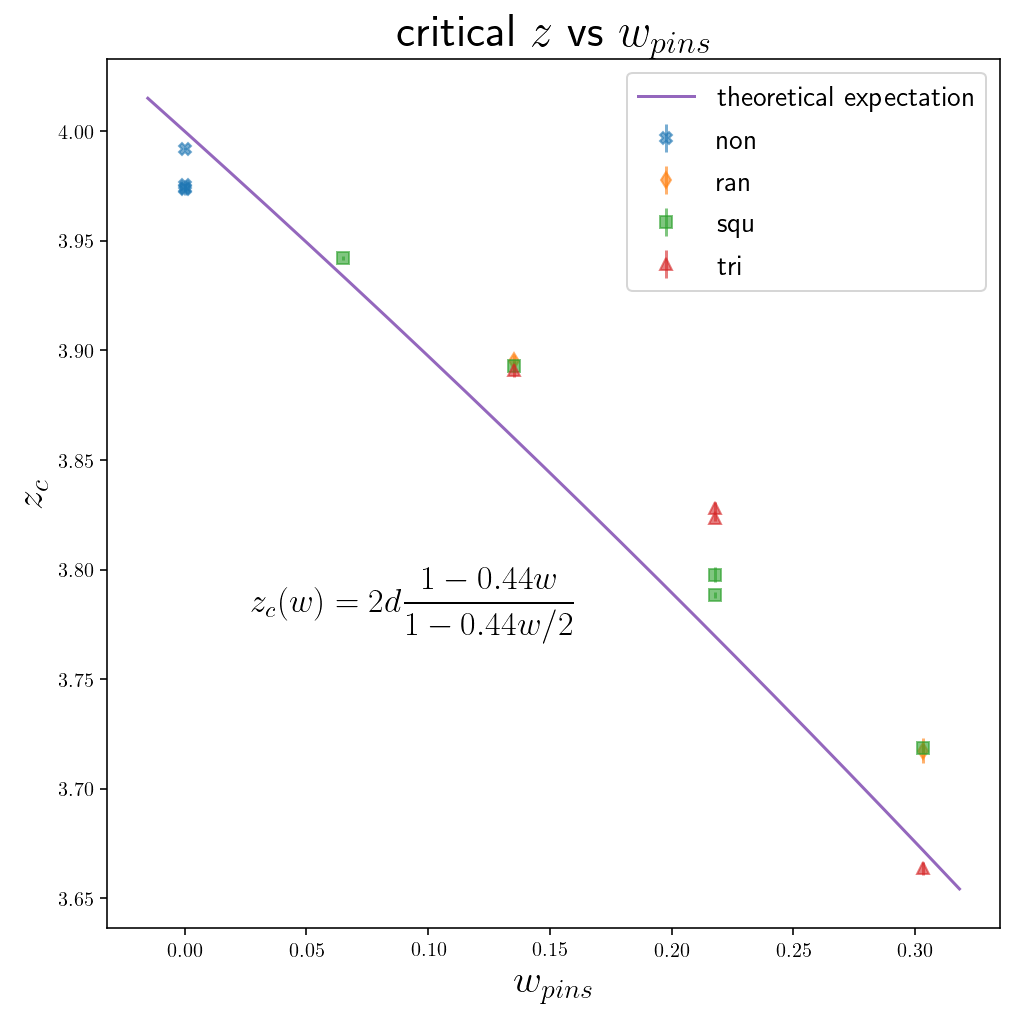

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os
matplotlib.rcParams['text.usetex'] = True

def z_fit(w, c):
    return 4*(1-c*w)/(1-c*w/2)

contactParameters = pd.read_csv('simulation_data/contact_number_parameters.txt', sep=' ', header=None, names=['trial','coefficient','z_iso','err1','err2', 'lambda'])
contactParameters['w_pins']=[0,0,0,0,36/266,64/294,36/266,64/294, 16/246, 64/294,64/294, 36/266,100/330,100/330,100/330]
plt.figure(figsize=(8,8))
contactParameters['geo']=contactParameters['trial'].transform(lambda x: x[:3])
#contactParameters.drop(contactParameters[contactParameters.geo=='non'].index, inplace=True)
for colorCounter, geometry in enumerate(contactParameters.groupby('geo'),0):
    if geometry[0]=='non':
        marker='X'
    elif geometry[0]=='squ':
        marker='s'
    elif geometry[0]=='tri':
        marker='^'
    elif geometry[0]=='ran':
        marker='d'
    plt.errorbar(geometry[1]['w_pins'], geometry[1]['z_iso'], yerr=geometry[1]['err2'], fmt=marker, alpha=0.6, label=geometry[0], color='C{}'.format(colorCounter))

xValues=np.linspace(*plt.xlim(), 1000)
params,cov=sp.curve_fit(z_fit, contactParameters['w_pins'],contactParameters['z_iso'])
#yValues=4*(1-xValues)/(1-xValues/2)
plt.plot(xValues,z_fit(xValues, params[0]), label='theoretical expectation', color='C4')
plt.figtext(0.25,0.4,r'$z_c(w)=2d\displaystyle\frac{1-%.2f w}{1-%.2f w/2}$' % (params[0],params[0]), fontsize=17)
plt.legend(fontsize = 14)
plt.ylabel('$z_c$', fontsize = 20)
plt.xlabel('$w_{pins}$', fontsize = 20)
plt.title('critical $z$ vs $w_{pins}$', fontsize = 23)
#plt.savefig('plots/presentation/z_c_vs_wpins-comparison-correction_term.png', dpi=300)

matplotlib.rcParams['text.usetex'] = False

## 1.4. (Deprecated). Finding contact number with NetworkX
After failing to effectively plot topology with NetworkX, we revisited the module, attempting to use its graph.neighbors() function to find contact numbers without too much fuss. Unfortunately, NetworkX is not well-suited to such large data sets, and this script, while theoretically functional, ends up being incredibly inefficient and has never finished running.

In [ ]:
import networkx as nx

contactNumbers=[]
entireFile['sourceNodes']=entireFile['x1'].round(6).astype('str')+' '+entireFile['y1'].round(6).astype('str')
entireFile['targetNodes']=entireFile['x2'].round(6).astype('str')+' '+entireFile['y2'].round(6).astype('str')
list_of_trials=entireFile.index.get_level_values('trialName')
for trial in list_of_trials:
#trialName=entireFile.index.get_level_values('trialName')[0] # get name of first trial
#headerNames=['geometry','seed','num','pins','small_radius','something'] # TODO: what is this last value in the header? pin spacing?
#trialInfo={}
#for key, label in zip(headerNames,trialName.split('-')): # retrieve info from name
#    trialInfo[key]=label
    bondInfo=entireFile.loc[[trial]]

    #print(bondInfo['sourceNodes'])
    network=nx.from_pandas_edgelist(bondInfo,'sourceNodes','targetNodes',edge_attr=True)

    nonPinEdges=[(node1,node2) for (node1,node2, data) in network.edges(data=True) if data['bondType']<3]
    nonPinGraph=nx.Graph(nonPinEdges)
    #print("average number of contact (no pins):", 2*nonPinGraph.number_of_edges()/nonPinGraph.number_of_nodes())
    #print("average number of contact (with pins):)", 2*network.number_of_edges()/network.number_of_nodes())
    meanContacts=2*nonPinGraph.number_of_edges()/nonPinGraph.number_of_nodes()
    for node in nonPinGraph.nodes:
        contactNumbers.append(len(list(nonPinGraph.neighbors(node))))

plt.hist(contactNumbers, bins=np.linspace(min(contactNumbers)-0.25,max(contactNumbers)+0.25, (max(contactNumbers)-min(contactNumbers)+1)*2),color='C0')
plt.title('Contact number barplot for {} lattice of {} pins, mean = {}'.format(trialInfo['geometry'],trialInfo['pins'],meanContacts))
plt.xlabel('Contact Number')
#plt.savefig('plots/contact_barplot_{}{}.png'.format(*[trialInfo[x] for x in ['geometry','pins']]), dpi=300)
plt.show()

## 1.5 Examining $N_{excess}$

In [0]:
#import matplotlib
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from scipy import stats
# What's really important: picking a fun color scheme
#colormap = matplotlib.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'r', '#FFFFFF', '#FFFFFF']) # classic
#colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
#plt.rc('axes',prop_cycle=colormap)

fig, (axRan, axSqu, axTri) = plt.subplots(3,1,figsize=(8,10))
for colorCounter, file in enumerate(files):
    N_pp=dataDict[file][dataDict[file].bondType<=2].groupby(level=0).size()
    N_pf=dataDict[file][dataDict[file].bondType>=3].groupby(level=0).size()
    num_particles=sort_particles(dataDict[file], types=[1,2]).drop_duplicates(keep='first').groupby('trialName').size()
    N_excess=N_pp+N_pf-2*num_particles-1
    N_pf=N_pf[N_excess>0]
    N_excess=N_excess[N_excess>0]
    regression=stats.linregress(N_pf,N_excess)
    yValues=np.array([0,50])
    xValues=(yValues-regression[1])/regression[0]
    if file[:3]=='ran':
        axRan.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
        axRan.plot(xValues,yValues, color='C{}'.format(colorCounter))
    elif file[:3]=='squ':
        axSqu.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
        axSqu.plot(xValues,yValues, color='C{}'.format(colorCounter))
    elif file[:3]=='tri':
        axTri.plot(N_pf, N_excess, 's', ms=2, label='{}, slope={slope:.2f}, r={r:.2f}'.format(file, slope=regression[0], r=regression[2]), alpha=0.6, color='C{}'.format(colorCounter))
        axTri.plot(xValues,yValues, color='C{}'.format(colorCounter))

for axis in [axRan,axSqu,axTri]:
    axis.set(aspect='equal',adjustable='datalim')
    axis.set_xlim(0,95)
    axis.set_ylim(0,50)
    axis.legend(loc='upper left')

plt.xlabel('$N_{pf}$')
axSqu.set_ylabel('$N_{excess}$')
fig.suptitle('$N_{excess}$ vs particle pin contacts', y=0.93)
#plt.savefig('plots/Nexcess_vs_Npf-July20-regressed.png', dpi=300)
plt.show()

# 2. Clumpiness Analysis

## 2.1. Find $n_6$ of Large Neighbors
Iterates through every trial identifying the number of large neighbors in n_6 for each large particle (not efficient). Writes to a text file so this doesn't have to be run too often.

In [0]:
from scipy import spatial

def get_large_neighbors(particles):
    # Uses scipy.spatial.KDTree to identify nearest six neighbors, then returns array of number of large neighbors for each large particle

    # Initialize data
    particles=particles.drop_duplicates(keep='first') # just want one instance of each particle, rather than once per contact
    particles=particles[particles.particleType>0] # remove pins
    tree=spatial.KDTree(list(zip(particles['x'],particles['y']))) # load coordinates as KDTree
    large_particles=particles[particles.particleType==2] # series of large particles, which we iterate over
    large_neighbors=np.array([],dtype='int16') # array to add number of neighbors for each particle to (within the trial)

    # Find neighbors of each particle
    try:
        for neighbor_index in tree.query(list(zip(large_particles['x'],large_particles['y'])),k=7)[1]: # Get indices of six closest particle neighbors (seven including self)
            try:
                neighborTypes=particles.iloc[neighbor_index].groupby('particleType').size() # count how many neighbors are large
                large_neighbors=np.append(large_neighbors,neighborTypes[2]) # add large neighbor count to array

            except IndexError: # Error case where a data set has fewer than six particles
                raise IndexError

        return large_neighbors

    except ValueError: # Error case where a data set has no large particles
        raise ValueError

def write_neighbors(neighbor_column):
    # Writes series of large neighbors as a new column in large_neighbors.txt for future reference

    # Load text file
    try:
        data = pd.read_csv('simulation_data/new_large_neighbors.txt', sep=' ', dtype='Int16')
    except:
        print('Note: simulation_data/new_large_neighbors.txt was empty or missing.')
        data=pd.DataFrame(dtype='Int16')

    data=pd.concat([data,neighbor_column], axis=1) # add new column to existing data
    data=data.loc[:,~data.columns.duplicated(keep='last')] # in case of duplicates, overwrite
    data.to_csv('simulation_data/new_large_neighbors.txt', sep = ' ', index=False) # write new data back to text file
    return data

def write_n_6(n6_column, file):
    # Writes series of n_6 values as a new column in corresponding Pressures file

    # Load text file
    filePath=file.split('/')
    filePath[-1]=filePath[-1].replace('BondInfo','Pressures')
    try:
        data = pd.read_csv('/'.join(filePath), sep=' ', index_col=0)
    except:
        print('Note: {} was empty or missing.'.format('/'.join(filePath)))
        data=pd.DataFrame()

    data['n_6']=n6_column # add new column to dataframe - this method of creating a column skips any values in n6_column whose trial names aren't in Pressures.txt (not actually jamming)
    data.index.name='trialName'
    data.to_csv('/'.join(filePath), sep = ' ') # write new data back to text file
    return data


for file in files:
    print('Processing:', file)
    # Find number of large particle neighbors for all trials in BondInfo (will take one or two minutes)
    large_neighbors=np.array([], dtype=np.int16) # initialize array for number of neighbors for entire BondInfo file
    n_6=[]
    for sorted_trial in sort_particles(dataDict[file]).groupby('trialName'):
        try:
            trial_neighbors=get_large_neighbors(sorted_trial[1])
            large_neighbors=np.append(large_neighbors, trial_neighbors-1) # add array of large neighbor values for this trial to the overall array
            n_6.append([sorted_trial[0],trial_neighbors[trial_neighbors==7].size/trial_neighbors.size]) # get n_6, percentage of large particles with six large neighbors
        except:
            print('EXCEPTION ON TRIAL', sorted_trial[0]) # this warns us if we can't get large neighbors for a trial, and skips over it

    # Export neighbor data
    n_6=np.asarray(n_6) # list to array
    n_6=pd.Series(n_6[:,1],index=n_6[:,0]) # array to series
    write_neighbors(pd.Series(large_neighbors, name=file, dtype='Int16'))
    write_n_6(n_6, filenames[file])

## 2.2. Analyze $n_6$ data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sp
import matplotlib
import pandas as pd
import os
import seaborn as sns

def read_neighbors(filename):
    data = pd.read_csv(filename, sep=' ').astype('Int16')
    return data

neighbors = read_neighbors('simulation_data/new_large_neighbors.txt')
neighbors = neighbors.reindex(sorted(neighbors.columns), axis=1)
plt.figure(figsize=(10,6))
for label, content in neighbors.items():
    sns.distplot(content.dropna(), hist=True, kde=True, bins=np.linspace(-0.5,6.5,8), hist_kws={'histtype':'step','linewidth':1,'alpha':0.8}, kde_kws={'linewidth': 0},
                 label='{name}, $n_6={n:.4f}$'.format(name=label, n=content[content==6].size/content.dropna().size))

plt.ylim(0,0.35)
plt.ylabel('Probability Density')
plt.xlabel('Number of Large Neighbors')
plt.title('Normalized Distribution of Closest Six Neighbors of Large Particles')
plt.legend()
#plt.savefig('plots/n_6_histogram-comparison.png', dpi=300)
plt.show()

In [0]:
neighborDensities=pd.DataFrame(dtype='float32')
for trial in neighbors:
    neighborDensities[trial]=neighbors.groupby(trial).size()/neighbors[trial].dropna().size

neighborDensities['mean']=neighborDensities.mean(axis=1)
neighborDensities=neighborDensities.transform(lambda x: x-x['non0'], axis=1)
neighborDensities['left']=neighborDensities.index-0.5
neighborDensities['right']=neighborDensities.index+0.5
xValues=pd.concat([neighborDensities['left'],neighborDensities['right']]).sort_index()

plt.figure(figsize=(8,6))
for trial in neighbors:
    plt.plot(xValues,neighborDensities[trial].repeat(2), label=trial, alpha=0.8)

plt.title('Closest Six Neighbors of Large Particles, normalized and zeroed to non0')
plt.xlabel('Number of Large Neighbors')
plt.legend()
#plt.savefig('plots/n_6_zeroed-comparison.png', dpi=300)
plt.show()

## 2.3. (Deprecated). $n_6$ vs. pressure

In [ ]:
plotGrid=[('squ_PressuresNp16_08-05.txt', 'squ16'), ('squ_PressuresNp64_08-05.txt', 'squ64'), ('tri_PressuresNp64_08-08.txt', 'tri64'), ('ZeroPinData/non_Pressures08-02.txt', 'non0')]
fig=plt.figure(figsize=(8,8))
for counter, (file, name) in enumerate(plotGrid, 1):
    fig.add_subplot(2,2,counter)
    n6_data=pd.read_csv('simulation_data/'+file, sep=' ', index_col=0)
    plt.plot(n6_data['pressure'], n6_data['n_6'], 'C{}.'.format(counter-1), alpha=0.3)
    plt.xlim(-0.1,2.2)
    plt.ylim(-0.01,0.15)
    plt.title(name)
#plt.legend()
fig.suptitle('n_6 vs. pressure', fontsize=14)
fig.text(0.5, 0.06, 'pressure', ha='center')
fig.text(0.04, 0.5, '$n_6$', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
#plt.savefig('plots/n_6_vs_pressure-comparison.png', dpi=300)

# 3. Force Distributions

## 3.1. Near-peak behavior

Text(0.5, 1.0, 'Contact Force Distributions, Peak Behavior')

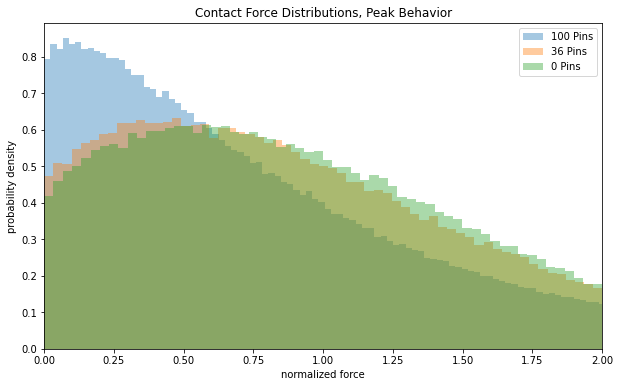

In [ ]:
from scipy import stats
plt.figure(figsize=(10,6))
for file, label in zip(['squ100_07-19','squ36_07-11','non0_07-11'],['100 Pins', '36 Pins', '0 Pins']):
    bw = 2*stats.iqr(dataDict[file]['normalizedForce']/1e6, rng=(25,75), scale=1.0, nan_policy='omit')/(len(dataDict[file])**(1/3))
    plt.hist(dataDict[file]['normalizedForce']/1e6, bins=int((dataDict[file]['normalizedForce'].max()/1e6-dataDict[file]['normalizedForce'].min()/1e6)/bw), density=True, alpha=0.4, label=label)
#plt.yscale('log')
plt.xlim(0,2)
plt.legend()
plt.xlabel('normalized force')
plt.ylabel('probability density')
plt.title('Contact Force Distributions, Peak Behavior')
#plt.savefig('plots/presentation/forceDistribution-peak.png', dpi=300)

## 3.2. Distributions zeroed to no-pin data

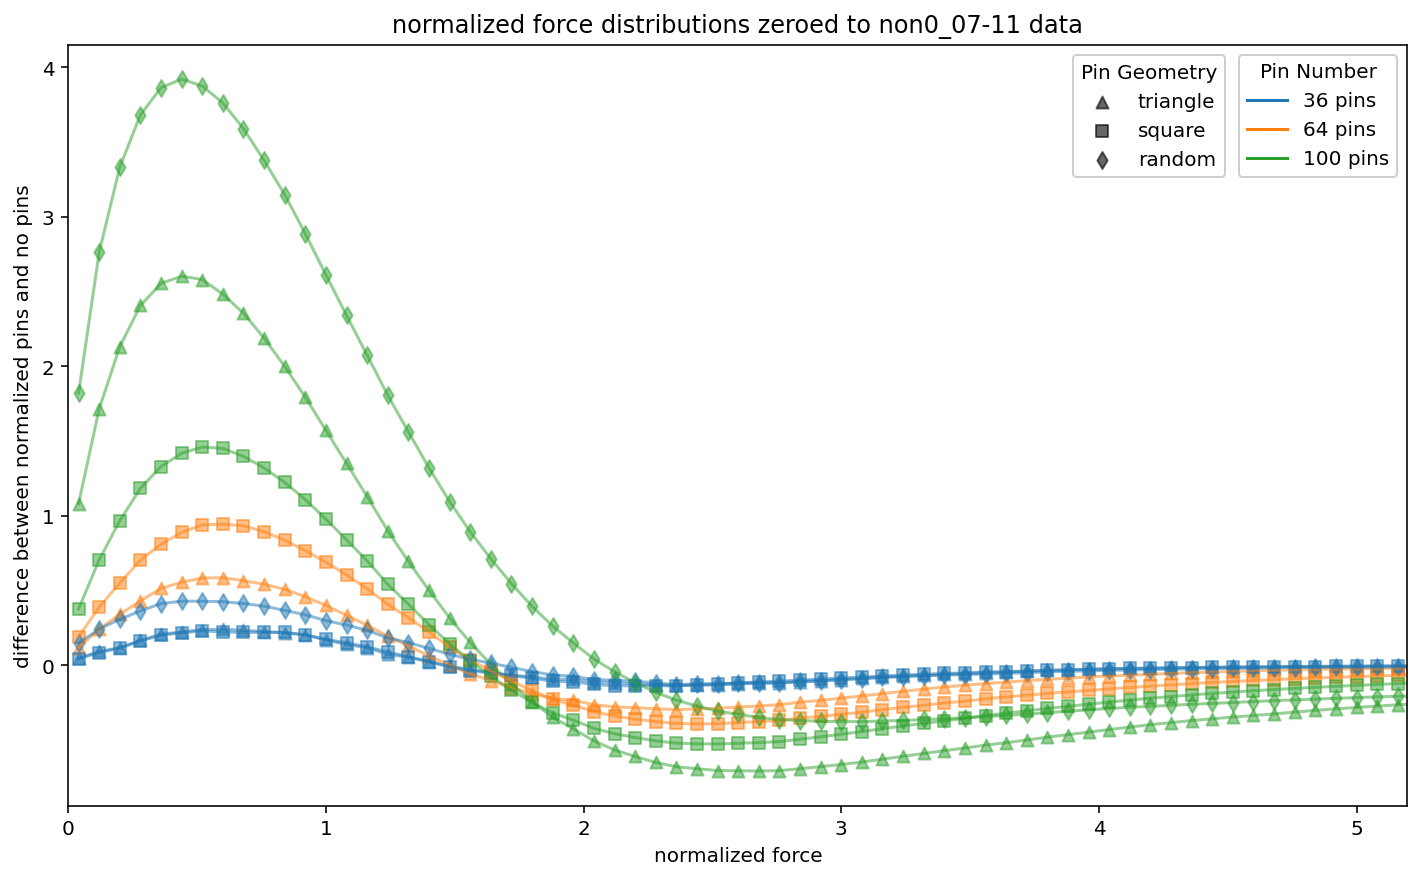

In [ ]:
from matplotlib.lines import Line2D

bw=0.08
bins=np.arange(0,100, bw)
nonHist=dataDict['non0_07-11'].groupby(pd.cut(dataDict['non0_07-11']['normalizedForce']/1e6, bins)).size()
nonHist=nonHist/(nonHist.sum()*bw)

for file in ['tri36_07-11', 'tri64_07-12', 'tri100_07-19','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11', 'ran100_07-19']:
    pinHist=dataDict[file].groupby(pd.cut(dataDict[file]['normalizedForce']/1e6, bins)).size()
    pinHist=pinHist/(pinHist.sum()*bw)
    if file[0:3]=='squ':
        marker='s'
    elif file[0:3]=='tri':
        marker='^'
    elif file[0:3]=='ran':
        marker='d'
    if int(file[3:5])==10:
        color='C2'
    elif int(file[3:5])==36:
        color='C0'
    elif int(file[3:5])==64:
        color='C1'
    plt.scatter(bins[:-1]+np.diff(bins)/2,(pinHist-nonHist).cumsum(), alpha=0.5, marker=marker, color=color)
    plt.plot(bins[:-1]+np.diff(bins)/2,(pinHist-nonHist).cumsum(), alpha=0.5, color=color)
plt.xlim(0,dataDict['non0_07-11']['normalizedForce'].max()/1e6)
plt.ylabel('difference between normalized pins and no pins')
plt.xlabel('normalized force')
plt.title('normalized force distributions zeroed to non0_07-11 data')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='d',c='k', alpha = 0.6, label='random')

particleLegend1 = plt.gca().legend(loc=(0.75,0.826),title='Pin Geometry',framealpha=0.95)
plt.gca().add_artist(particleLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = plt.gca().legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='upper right',title='Pin Number',framealpha=0.95)

#plt.savefig('plots/normalized_force_difference-july2020.png', dpi=300)

## 3.3. Power law fits on force tails

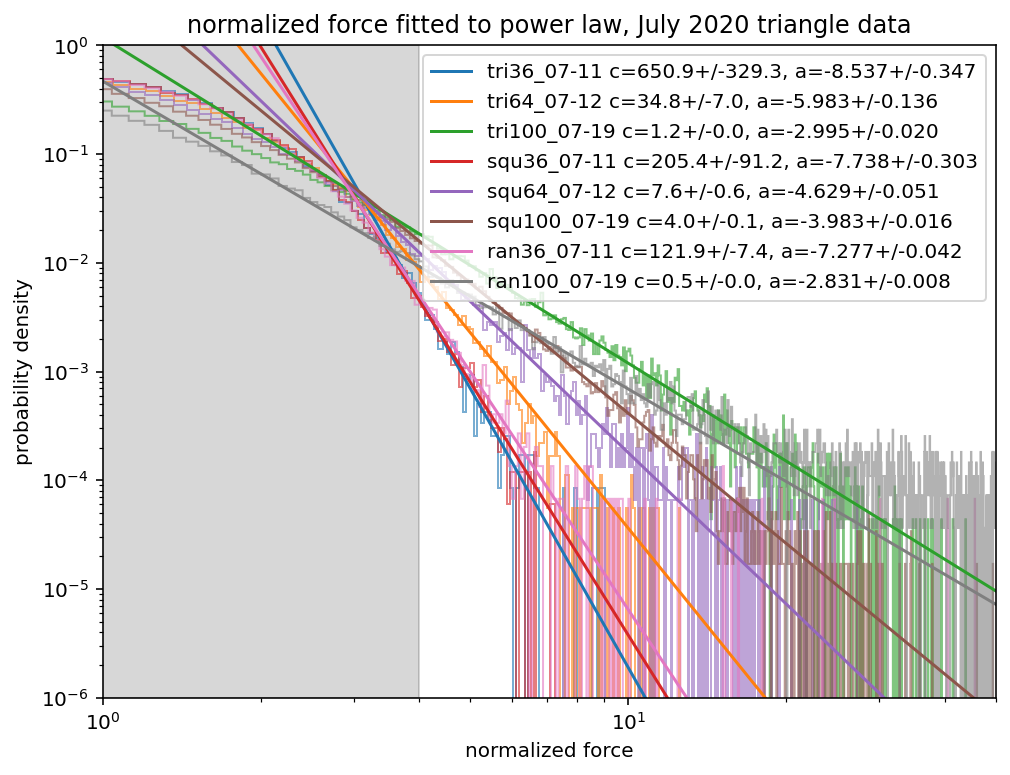

In [ ]:
def power_law(x, c, alpha):
    return c*(x**alpha)

a=[]
pindensity=[]
geometry=[]
bw=0.08
plt.figure(figsize=(8,6))
for counter, file in enumerate(['tri36_07-11', 'tri64_07-12', 'tri100_07-19','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11', 'ran100_07-19']):
    n, bins = plt.hist(dataDict[file]['normalizedForce']/1e6, bins=int(1e-6*dataDict[file]['normalizedForce'].max()/bw), histtype='step', color='C{}'.format(counter), alpha=0.6, density=True)[:2]
    bins=bins[:-1]+np.diff(bins)/2
    parameters, covariance = sp.curve_fit(power_law, bins[bins>4], n[bins>4], maxfev=1000000)
    error=np.sqrt(np.diag(covariance))
    xrange=np.linspace(1e-5,50, 1000)
    a.append(parameters[1])
    geometry.append(file[0:3])
    if int(file[3:5])==10:
        pinnumber=100
    else:
        pinnumber=int(file[3:5])
    pindensity.append(int(pinnumber)/(230+int(pinnumber)))
    plt.ylim(1e-6,1)
    plt.xlim(1,50)
    plt.loglog(xrange, power_law(xrange, parameters[0], parameters[1]), color='C{}'.format(counter), label='{} c={c:.1f}+/-{ce:.1f}, a={a:.3f}+/-{ae:.3f}'.format(file, c=parameters[0],ce=error[0],a=parameters[1],ae=error[1]))
    plt.legend()
    #plt.yscale('log')
    plt.axvspan(0,4,alpha=0.02,color='k')
    plt.title('normalized force fitted to power law, July 2020 triangle data')
    plt.xlabel('normalized force')
    plt.ylabel('probability density')
    #plt.savefig('plots/normalized_force-loglog_power_fits-tri.png', dpi=300)
alphaFrame=pd.DataFrame({'pindensity':pindensity,'alpha':a,'geometry':geometry})

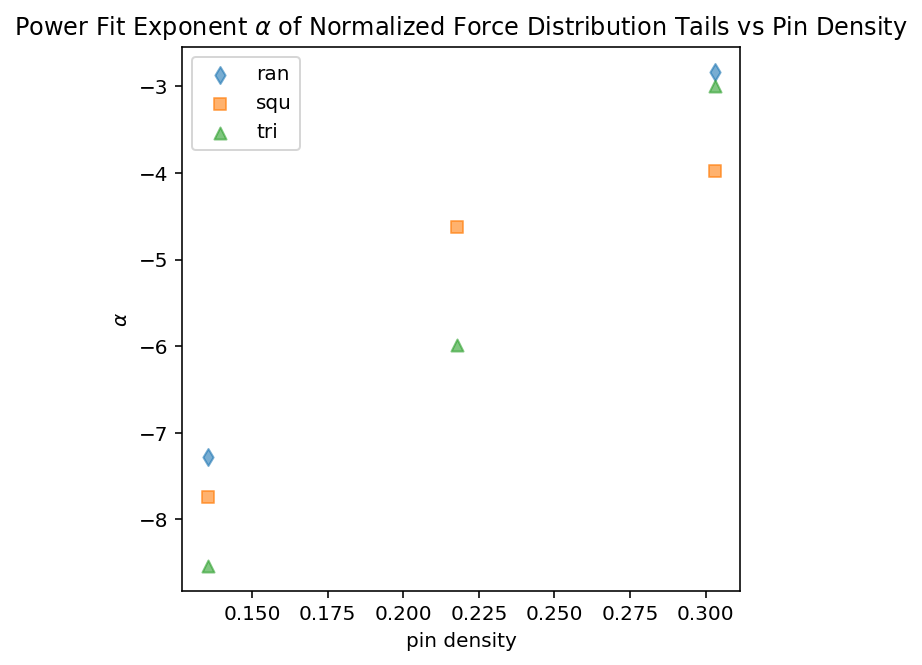

In [ ]:
plt.figure(figsize=(5,5))
for colorCounter, geo in enumerate(alphaFrame.groupby('geometry')):
    if geo[0]=='non':
        marker='X'
    elif geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    elif geo[0]=='ran':
        marker='d'
    plt.scatter(geo[1]['pindensity'], geo[1]['alpha'],  marker=marker, alpha=0.6, label=geo[0], color='C{}'.format(colorCounter))
plt.ylabel(r'$\alpha$')
plt.xlabel('pin density')
plt.title(r'Power Fit Exponent $\alpha$ of Normalized Force Distribution Tails vs Pin Density')
plt.legend()
plt.savefig('plots/force_distribution_exponents-july2020.png', dpi=300)

## 3.4. Weak force behavior, adjusted for bucklers

7
AxesSubplot(0.125,0.125;0.227941x0.755) [2.79398286 1.63043387] [2.19707122 1.22166192]


13
AxesSubplot(0.398529,0.125;0.227941x0.755) [0.82665829 1.05125233] [1.55362365 1.04483384]


27
AxesSubplot(0.672059,0.125;0.227941x0.755) [1.49220103 0.7701193 ] [1.4398792  0.58326945]


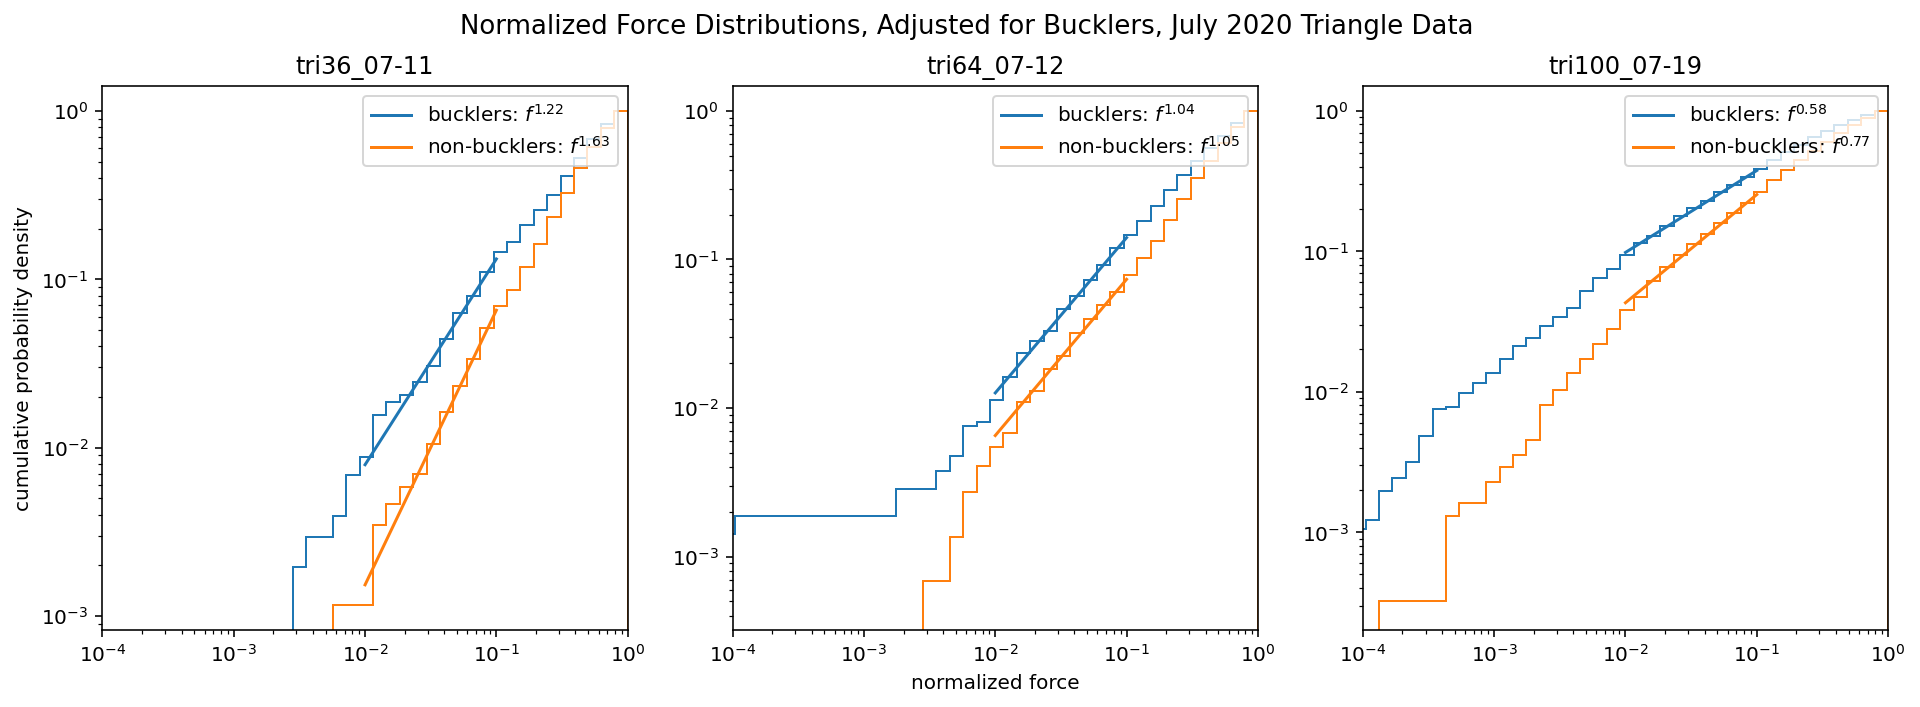

In [ ]:
def power_law(x, c, alpha):
    return c*(x**alpha)

#contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
cutoff=1
pressureCutoff=1e-2
bw=0.02
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for file, ax in zip(['tri36_07-11', 'tri64_07-12', 'tri100_07-19'], axes):

    # get data
    bucklers=dataDict[file][['x1','y1','x2','y2','normalizedForce']].copy()
    bucklers=pd.concat([bucklers[['x1','y1','normalizedForce']].rename({'x1':'x','y1':'y'}, axis='columns'),bucklers[['x2','y2','normalizedForce']].rename({'x2':'x','y2':'y'}, axis='columns')])
    # here we end up double-counting each bond, but this is negated by the normalized histogram.

    # filter for 3-contact particles
    bucklers['contacts']=bucklers.groupby(['trialName','x','y'])['normalizedForce'].transform('size')
    bucklers=bucklers[bucklers.contacts==3]['normalizedForce']

    # filter for only weak force bonds
    bucklers=bucklers[bucklers<cutoff*1e6]

    # filter for only low pressure trials
    pressures=get_pressures(filenames[file])
    bucklers=bucklers.loc[pressures[pressures<pressureCutoff].index]
    print(len(pressures[pressures<pressureCutoff].index))

    # get not-bucklers and plot
    notbucklers=dataDict[file]['normalizedForce'].loc[pressures[pressures<pressureCutoff].index].drop(bucklers.index)
    n_bucklers = ax.hist(bucklers/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[0]
    n_notbucklers, bins = ax.hist(notbucklers[notbucklers<cutoff*1e6]/1e6, bins=10**np.linspace(-5,0,50), histtype='step', density=True, cumulative=True)[:2]
    bins=bins[:-1]+np.diff(bins)/2
    p_notbucklers, cov_notbucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_notbucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)
    p_bucklers, cov_bucklers = sp.curve_fit(power_law, bins[(bins>1e-2)&(bins<1e-1)], n_bucklers[(bins>1e-2)&(bins<1e-1)], maxfev=1000000)
    xrange=np.linspace(1e-2,0.1,1000)
    ax.plot(xrange, power_law(xrange, p_bucklers[0], p_bucklers[1]), color='C0', label=r'bucklers: $f^{%.2f}$' % p_bucklers[1])
    ax.plot(xrange, power_law(xrange, p_notbucklers[0], p_notbucklers[1]), color='C1', label=r'non-bucklers: $f^{%.2f}$' % p_notbucklers[1])
    print(ax, p_notbucklers, p_bucklers)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(file)
    ax.set_xlim(1e-4,1)
    ax.legend()
axes[0].set_ylabel('cumulative probability density')
axes[1].set_xlabel('normalized force')
fig.suptitle('Normalized Force Distributions, Adjusted for Bucklers, July 2020 Triangle Data', fontsize=13)
#plt.savefig('plots/buckler_adjusted-cumulative_force_dist-tri.png', dpi=300)

## 3.5 Loglog Very Weak Force Distributions

14
8
37
7
13
27


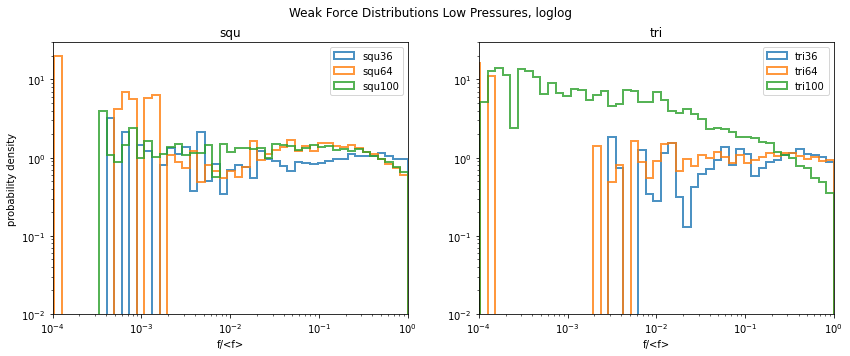

In [62]:
fileGroups = [files[1:4], files[6:]]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pressureCutoff=1e-2
for fileGroup,ax in zip(fileGroups, axes):

    for file in fileGroup:
        pressures=get_pressures(filenames[file])
        #print(len(pressures[pressures<pressureCutoff].index))
        ax.hist(dataDict[file].loc[pressures[pressures<pressureCutoff].index]['normalizedForce']/1e6, histtype='step', bins=10**np.linspace(-5,0,60), alpha=0.8, linewidth=2, density=True, label=file.split('_')[0])    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4,1)
    ax.set_ylim(1e-2, 30)
    ax.set_title(fileGroup[0][0:3])
    ax.legend()
    ax.set_xlabel('f/<f>')
axes[0].set_ylabel('probability density')
fig.suptitle('Weak Force Distributions Low Pressures, loglog')
#fig.savefig('plots/weakforcedistribution-low_pressure-loglog-July2020.jpg', dpi=300)

## 3.6. Pressure Mean Force Behavior

[['non0_07-11', 'squ36_07-11', 'squ64_07-12', 'squ100_07-19'], ['non0_07-11', 'tri36_07-11', 'tri64_07-12', 'tri100_07-19'], ['non0_07-11', 'ran36_07-11', 'ran100_07-19']]


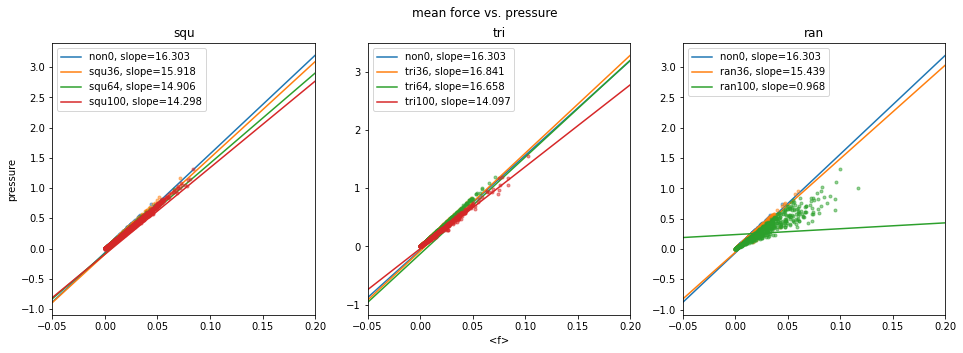

In [29]:
from scipy import stats

dataDict[files[0]].groupby('trialName')['force'].mean().abs()
get_pressures(filenames[files[0]])

fig, axes = plt.subplots(1,3, figsize=(16,5))
fileGroups = [files[0:4], [files[0]]+files[6:], [files[0]]+files[4:6]]
print(fileGroups)
for fileGroup, ax in zip(fileGroups, axes):
    for colorCounter, file in enumerate(fileGroup):
        slope, intercept, r, p, stderr = stats.linregress(dataDict[file].groupby('trialName')['force'].mean().abs(),get_pressures(filenames[file]))
        ax.plot(dataDict[file].groupby('trialName')['force'].mean().abs(),get_pressures(filenames[file]), '.', color='C{}'.format(colorCounter), alpha=0.5)
        ax.plot([-0.05,0.2], slope*np.array([-0.05,0.2]+intercept),  color='C{}'.format(colorCounter), label='{}, slope={m:.3f}'.format(file.split('_')[0],m=slope))
    ax.set_xlim(-0.05,0.2)
    ax.set_title(fileGroup[1][:3])
    ax.legend()
axes[1].set_xlabel('<f>')
axes[0].set_ylabel('pressure')
fig.suptitle('mean force vs. pressure')

fig.savefig('plots/meanforce_vs_pressure-July2020.jpg', dpi=300)

## 3.7. Mean Force , Peak Normalized Force, and Power Law Exponent
### function of $\lambda$ and $\alpha$  for pressure range $0.05$ to $0.1$

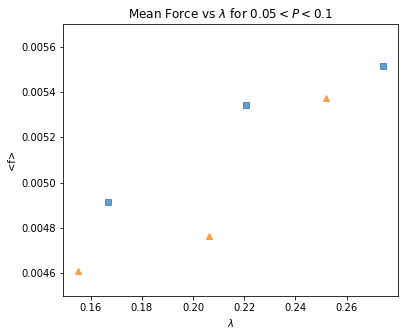

In [221]:
#finding mean force values in range of pressures
pressureCutoff=(5e-2,1e-1)
lambdaValues=[]
meanForces=[]
geos=[]

for file in files:
    if file[:3]!='non' and file[:3]!='ran':
        fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
        pressures=get_pressures(filenames[file])
        meanForce=dataDict[file].loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index]['force'].abs().mean()
        
        meanForces.append(meanForce)
        lambdaValues.append(fileData[-2]/fileData[-1])
        geos.append(dataDict[file].index.get_level_values(0)[0].split('-')[0])

plt.figure(figsize=(6,5))
for geo in pd.DataFrame({'lambda':lambdaValues,'meanForce':meanForces,'geometry':geos}).groupby('geometry'):
    if geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    
    plt.plot(geo[1]['lambda'], geo[1]['meanForce'], marker, alpha=0.7)
plt.ylim(4.5e-3,5.7e-3)
plt.title('Mean Force vs $\lambda$ for $0.05<P<0.1$')
plt.ylabel('<f>')
plt.xlabel('$\lambda$')
#fig.savefig('plots/meanforce_vs_lambda-medpressure-July2020.jpg', dpi=300)

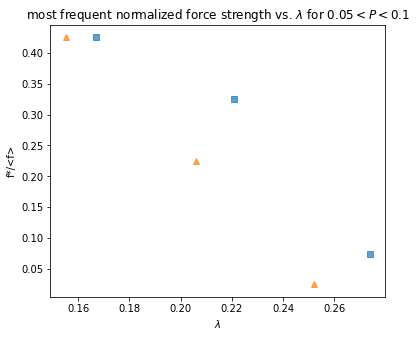

In [223]:
#peak normalized force, same pressure range (0.05,0.10)
pressureCutoff=(5e-2,1e-1)
bw=0.05
bins=np.arange(0,2,bw)
lambdaValues=[]
peakForces=[]
geos=[]
plt.figure(figsize=(10,6))
colorCounter=0
for file in files:
    if file[:3]!='non' and file[:3]!='ran':
        fileData=np.array(dataDict[file].index.get_level_values(0)[0].split('-')[2:]).astype('float')
        pressures=get_pressures(filenames[file])
        filteredForce=dataDict[file].loc[pressures[(pressures>pressureCutoff[0])&(pressures<pressureCutoff[1])].index]['normalizedForce']/1e6
        peakForce=filteredForce.groupby(pd.cut(filteredForce, bins)).size()/(len(filteredForce)*bw)
        xValues=[iv.mid for iv in peakForce.index.values]
        plt.plot(xValues, peakForce, color='C{}'.format(colorCounter), alpha=0.5)
        #plt.hist(filteredForce, bins=bins, color='C{}'.format(colorCounter), density=True, alpha=0.5, histtype='step')
        plt.scatter(peakForce.idxmax().mid, peakForce.max(), color='C{}'.format(colorCounter), label=file.split('_')[0])
        peakForces.append(peakForce.idxmax().mid)
        lambdaValues.append(fileData[-2]/fileData[-1])
        geos.append(dataDict[file].index.get_level_values(0)[0].split('-')[0])
        colorCounter+=1
plt.yscale('log')
plt.title('normalized force distributions for $0.05<P<0.1$')
plt.xlabel('$<f>$')
plt.ylabel('probability density')
plt.legend()
#plt.savefig('plots/forcedistributions-withpeaks-medpressure.jpg', dpi=300)
plt.close()

plt.figure(figsize=(6,5))
for geo in pd.DataFrame({'lambda':lambdaValues,'peak':peakForces,'geometry':geos}).groupby('geometry'):
    if geo[0]=='squ':
        marker='s'
    elif geo[0]=='tri':
        marker='^'
    
    plt.plot(geo[1]['lambda'], geo[1]['peak'], marker, alpha=0.7)
plt.title('most frequent normalized force strength vs. $\lambda$ for $0.05<P<0.1$')
plt.ylabel('f*/<f>')
plt.xlabel('$\lambda$')
#fig.savefig('plots/peakforce_vs_lambda-medpressure-July2020.jpg', dpi=300)

In [151]:
peakForces

[normalizedForce
 (0.0, 0.08]    NaN
 (0.08, 0.16]   NaN
 (0.16, 0.24]   NaN
 (0.24, 0.32]   NaN
 (0.32, 0.4]    NaN
 (0.4, 0.48]    NaN
 (0.48, 0.56]   NaN
 (0.56, 0.64]   NaN
 (0.64, 0.72]   NaN
 (0.72, 0.8]    NaN
 (0.8, 0.88]    NaN
 (0.88, 0.96]   NaN
 (0.96, 1.04]   NaN
 (1.04, 1.12]   NaN
 (1.12, 1.2]    NaN
 (1.2, 1.28]    NaN
 (1.28, 1.36]   NaN
 (1.36, 1.44]   NaN
 (1.44, 1.52]   NaN
 (1.52, 1.6]    NaN
 (1.6, 1.68]    NaN
 (1.68, 1.76]   NaN
 (1.76, 1.84]   NaN
 (1.84, 1.92]   NaN
 Name: normalizedForce, dtype: float64,
 normalizedForce
 (0.0, 0.08]    NaN
 (0.08, 0.16]   NaN
 (0.16, 0.24]   NaN
 (0.24, 0.32]   NaN
 (0.32, 0.4]    NaN
 (0.4, 0.48]    NaN
 (0.48, 0.56]   NaN
 (0.56, 0.64]   NaN
 (0.64, 0.72]   NaN
 (0.72, 0.8]    NaN
 (0.8, 0.88]    NaN
 (0.88, 0.96]   NaN
 (0.96, 1.04]   NaN
 (1.04, 1.12]   NaN
 (1.12, 1.2]    NaN
 (1.2, 1.28]    NaN
 (1.28, 1.36]   NaN
 (1.36, 1.44]   NaN
 (1.44, 1.52]   NaN
 (1.52, 1.6]    NaN
 (1.6, 1.68]    NaN
 (1.68, 1.76]   NaN
 (1.76

# 4. Analysis of Weak Particle-Pin "Scaffolding" Contacts

## 4.1 Weak particle-pin bar plots

In [0]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts') for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
for file in files:
    contactsDict[file].set_index(['trialName','x','y'], inplace=True)
    weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=5e3)][['x1','y1','x2','y2','normalizedForce']].copy()
    weakPins['contactsParticle']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    weakPins['contactsPin']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allPins=dataDict[file][(dataDict[file].bondType>=3)][['x1','y1','x2','y2','normalizedForce']].copy()
    allPins['contactsParticle']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    allPins['contactsPin']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    fig, (axAll, axWeak) = plt.subplots(1,2, figsize=(12,4))
    for ax, data in [(axAll, allPins), (axWeak, weakPins)]:
        ax.hist(data['contactsParticle'],bins=np.linspace(2.5,7.5,6), density=True, label='particle contacts')
        ax.hist(data['contactsPin'],bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contacts')
        ax.set_ylim(0,0.9)
        ax.set_axisbelow(True)
        ax.grid(linestyle='dashed')
        ax.set_xlabel('number of contacts')
    axWeak.set_title('weak contacts, normalized force < 0.005')
    axAll.set_title('all contacts')
    axWeak.legend()
    fig.subplots_adjust(top=0.85)
    plt.suptitle('normalized distribution of particle/pin contacts, {}'.format(file), fontsize=14, x=0.52)
    #plt.savefig('plots/particlePinContactNumbers/particle_pin_contact_distribution-{}.png'.format(file),dpi=300)
    plt.show()

## 4.2. Aggregated weak particle-pin bar plots

In [0]:
allDF = pd.DataFrame()
weakDF = pd.DataFrame()
for file in files:
    contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts') for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
    contactsDict[file].set_index(['trialName','x','y'], inplace=True)
    weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=5e-3)][['x1','y1','x2','y2','normalizedForce']].copy()
    weakPins['contactsParticle']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    weakPins['contactsPin']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allPins=dataDict[file][(dataDict[file].bondType>=3)][['x1','y1','x2','y2','normalizedForce']].copy()
    allPins['contactsParticle']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
    allPins['contactsPin']=allPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
    allDF = pd.concat([allDF,allPins[['contactsParticle', 'contactsPin']]])
    weakDF = pd.concat([weakDF,weakPins[['contactsParticle','contactsPin']]])

In [0]:
fig, (axAll, axWeak) = plt.subplots(1,2, figsize=(12,4))
for ax, data in [(axAll, allDF), (axWeak, weakDF)]:
    ax.hist(data['contactsParticle'],bins=np.linspace(2.5,7.5,6), density=True, label='particle contacts')
    ax.hist(data['contactsPin'],bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contacts')
    ax.set_ylim(0,0.9)
    ax.set_axisbelow(True)
    ax.grid(linestyle='dashed')
    ax.set_xlabel('number of contacts')
axWeak.set_title('weak contacts, normalized force < 0.005')
axAll.set_title('all contacts')
axWeak.legend()
fig.subplots_adjust(top=0.85)
plt.suptitle('normalized distribution of particle/pin contacts, aggregated', fontsize=14, x=0.52)
#plt.savefig('plots/particlePinContactNumbers/particle_pin_contact_distribution-aggregate.png',dpi=300)
#plt.close()

## 4.3. Bar plots animated for varying force thresholds

In [0]:
contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
file='squ100_07-19'
cutoffs=0.5**np.linspace(-1,10,20)
weakPinDF=pd.DataFrame(columns=['file','cutoff','avgParticle','particleErr','avgPin','pinErr'])
for file in ['tri36_07-11', 'tri64_07-12', 'tri100_07-19','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11', 'ran100_07-19']:
    for cutoff in cutoffs:
        if file[:4] != 'non0':
            weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=cutoff*1e6)][['x1','y1','x2','y2','normalizedForce']].copy()
            weakPins['contactsParticle']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x2'],x['y2']]['contacts'], axis=1)
            weakPins['contactsPin']=weakPins.apply(lambda x: contactsDict[file].loc[x.name[0],x['x1'],x['y1']]['contacts'], axis=1)
            weakPinDF=weakPinDF.append({'file':file, 'cutoff':cutoff,
                                        'avgParticle':weakPins['contactsParticle'].mean(),'particleErr':weakPins['contactsParticle'].sem(),
                                        'avgPin':weakPins['contactsPin'].mean(),'pinErr':weakPins['contactsPin'].sem()}, ignore_index=True)
            fig, axWeak = plt.subplots(1,1, figsize=(10,6))
            axWeak.hist(weakPins['contactsParticle'],bins=np.linspace(2.5,7.5,6), density=True, label='particle contact numbers')
            axWeak.hist(weakPins['contactsPin'],bins=np.linspace(0.5,2.5,3), density=True, label = 'pin contact numbers')
            axWeak.set_ylim(0,0.9)
            axWeak.set_axisbelow(True)
            axWeak.grid(linestyle='dashed')
            axWeak.set_xlabel('number of contacts')
            axWeak.set_title('normalized force < {c:.3f}'.format(c=cutoff))
            axWeak.legend()
            fig.subplots_adjust(top=0.9)
            plt.suptitle('constituent contact numbers for particle-pin contacts, {}'.format(file), fontsize=14, x=0.52)
            plt.savefig('plots/bucklers/{}_cutoff-{}.png'.format(file, cutoff),dpi=300)
            plt.show()

In [0]:
import imageio
from glob import glob

image_list=[]
for imagename in sorted(glob('plots/bucklers/*.png'), reverse=True): # get all .pngs in the directory
    image_list.append(imageio.imread(imagename))
imageio.mimwrite('plots/bucklers/bucklers_animated-{}-.gif'.format(file), image_list, duration = 0.3)

## 4.4. Average scaffolding contact number vs. force threshold

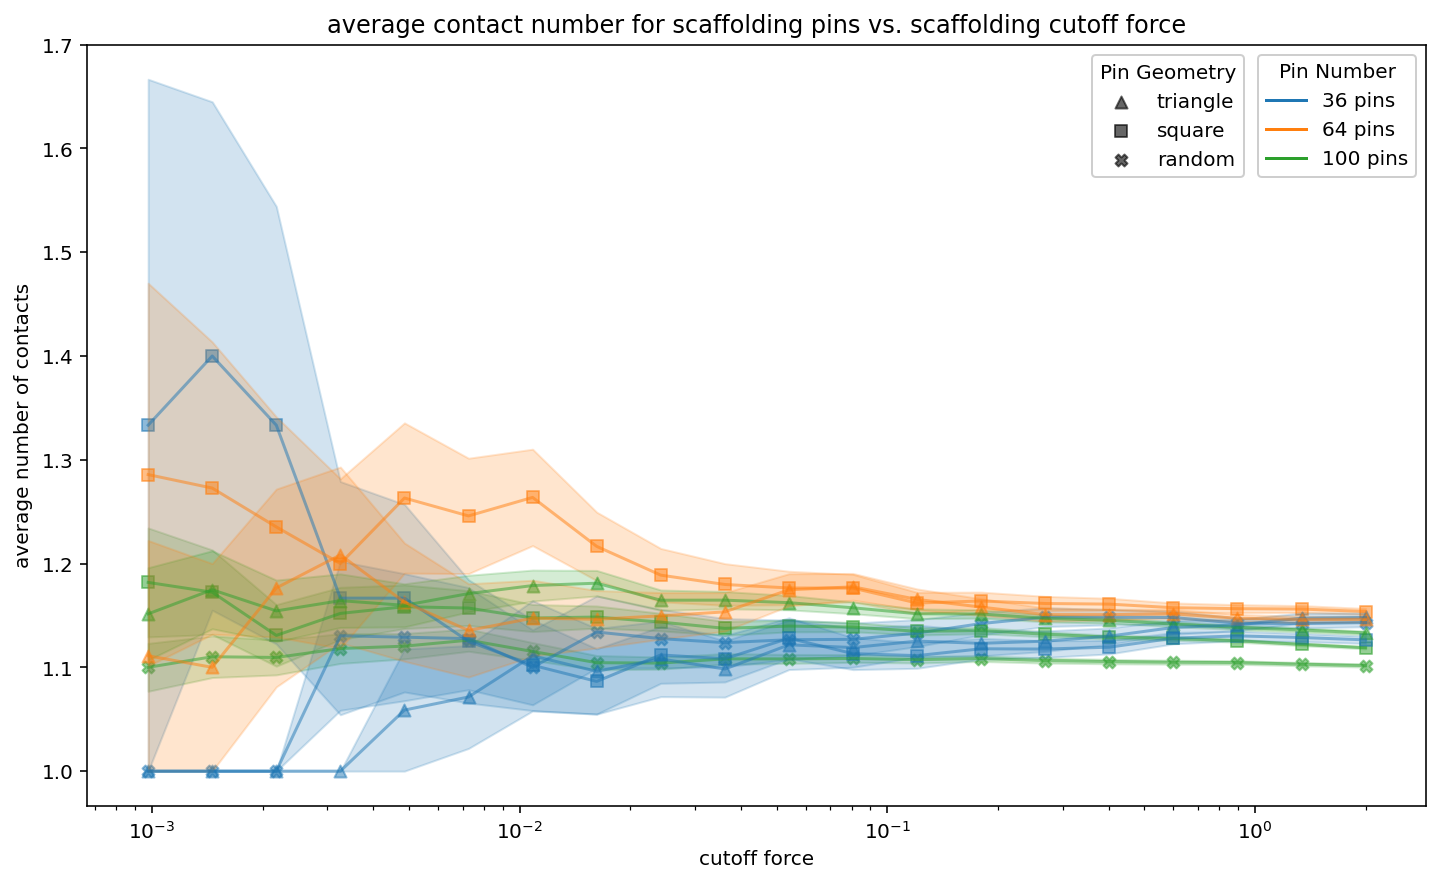

In [ ]:
for fileDF in weakPinDF.groupby('file'):
    if fileDF[0][0:3]=='squ':
        marker='s'
    elif fileDF[0][0:3]=='tri':
        marker='^'
    elif fileDF[0][0:3]=='ran':
        marker='X'
    if int(fileDF[0][3:5])==10:
        color='C2'
    elif int(fileDF[0][3:5])==36:
        color='C0'
    elif int(fileDF[0][3:5])==64:
        color='C1'
    plt.scatter(fileDF[1]['cutoff'],fileDF[1]['avgPin'], alpha=0.5, marker=marker, color=color)
    plt.plot(fileDF[1]['cutoff'],fileDF[1]['avgPin'], color=color, alpha=0.5)
    plt.fill_between(fileDF[1]['cutoff'],y1=fileDF[1]['avgPin']+fileDF[1]['pinErr'],y2=fileDF[1]['avgPin']-fileDF[1]['pinErr'], color=color, alpha=0.2)

plt.title('average contact number for scaffolding pins vs. scaffolding cutoff force')
plt.ylabel('average number of contacts')
plt.xlabel('cutoff force')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='X',c='k', alpha = 0.6, label='random')

PinLegend1 = plt.gca().legend(loc=(0.75,0.826),title='Pin Geometry',framealpha=0.95)
plt.gca().add_artist(PinLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = plt.gca().legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='upper right',title='Pin Number',framealpha=0.95)
plt.xscale('log')

#plt.savefig('plots/avg_scaffolding_particle_z_vs_cutoff-july2020.png', dpi=300)

## 4.5. Percentage of weak contacts which are scaffolding

In [0]:
#contactsDict={file:sort_particles(dataDict[file]).groupby(['x','y','trialName']).size().reset_index(name='contacts').set_index(['trialName','x','y']) for file in (files)} # dataframe of particle coordinates, with contact number and trial labeled
file='squ100_07-19'
cutoffs=0.5**np.linspace(-1,10,20)
threeBondDF=pd.DataFrame(columns=['file','cutoff','percentAll','percentPins'])
for file in ['tri36_07-11', 'tri64_07-12', 'tri100_07-19','squ36_07-11', 'squ64_07-12', 'squ100_07-19','ran36_07-11', 'ran100_07-19']:
    for cutoff in cutoffs:
        if file[:4] != 'non0':
            weakParticles=pd.concat([contactsDict[file].sort_index(),
                                     sort_particles(dataDict[file][(dataDict[file].normalizedForce<=cutoff*1e6)]).groupby(['trialName','x','y','particleType']).size().reset_index().set_index(['trialName','x','y'])['particleType']],axis=1,join='inner')
            weakPins=dataDict[file][(dataDict[file].bondType>=3)&(dataDict[file].normalizedForce<=cutoff*1e6)][['x2','y2']].copy()
            weakPins=weakParticles.loc[weakPins.rename(columns=lambda x: x[0]).reset_index().set_index(['trialName','x','y']).index]
            weakPins=weakPins[weakPins.contacts==3]
            threeBondDF=threeBondDF.append({'file':file, 'cutoff':cutoff,'percentAll':len(weakParticles[weakParticles.contacts==3].index)/len(weakParticles.index), 'percentPins':len(weakPins.index)/len(weakParticles.index)}, ignore_index=True)

threeBondDF.set_index(['file','cutoff'], inplace=True)

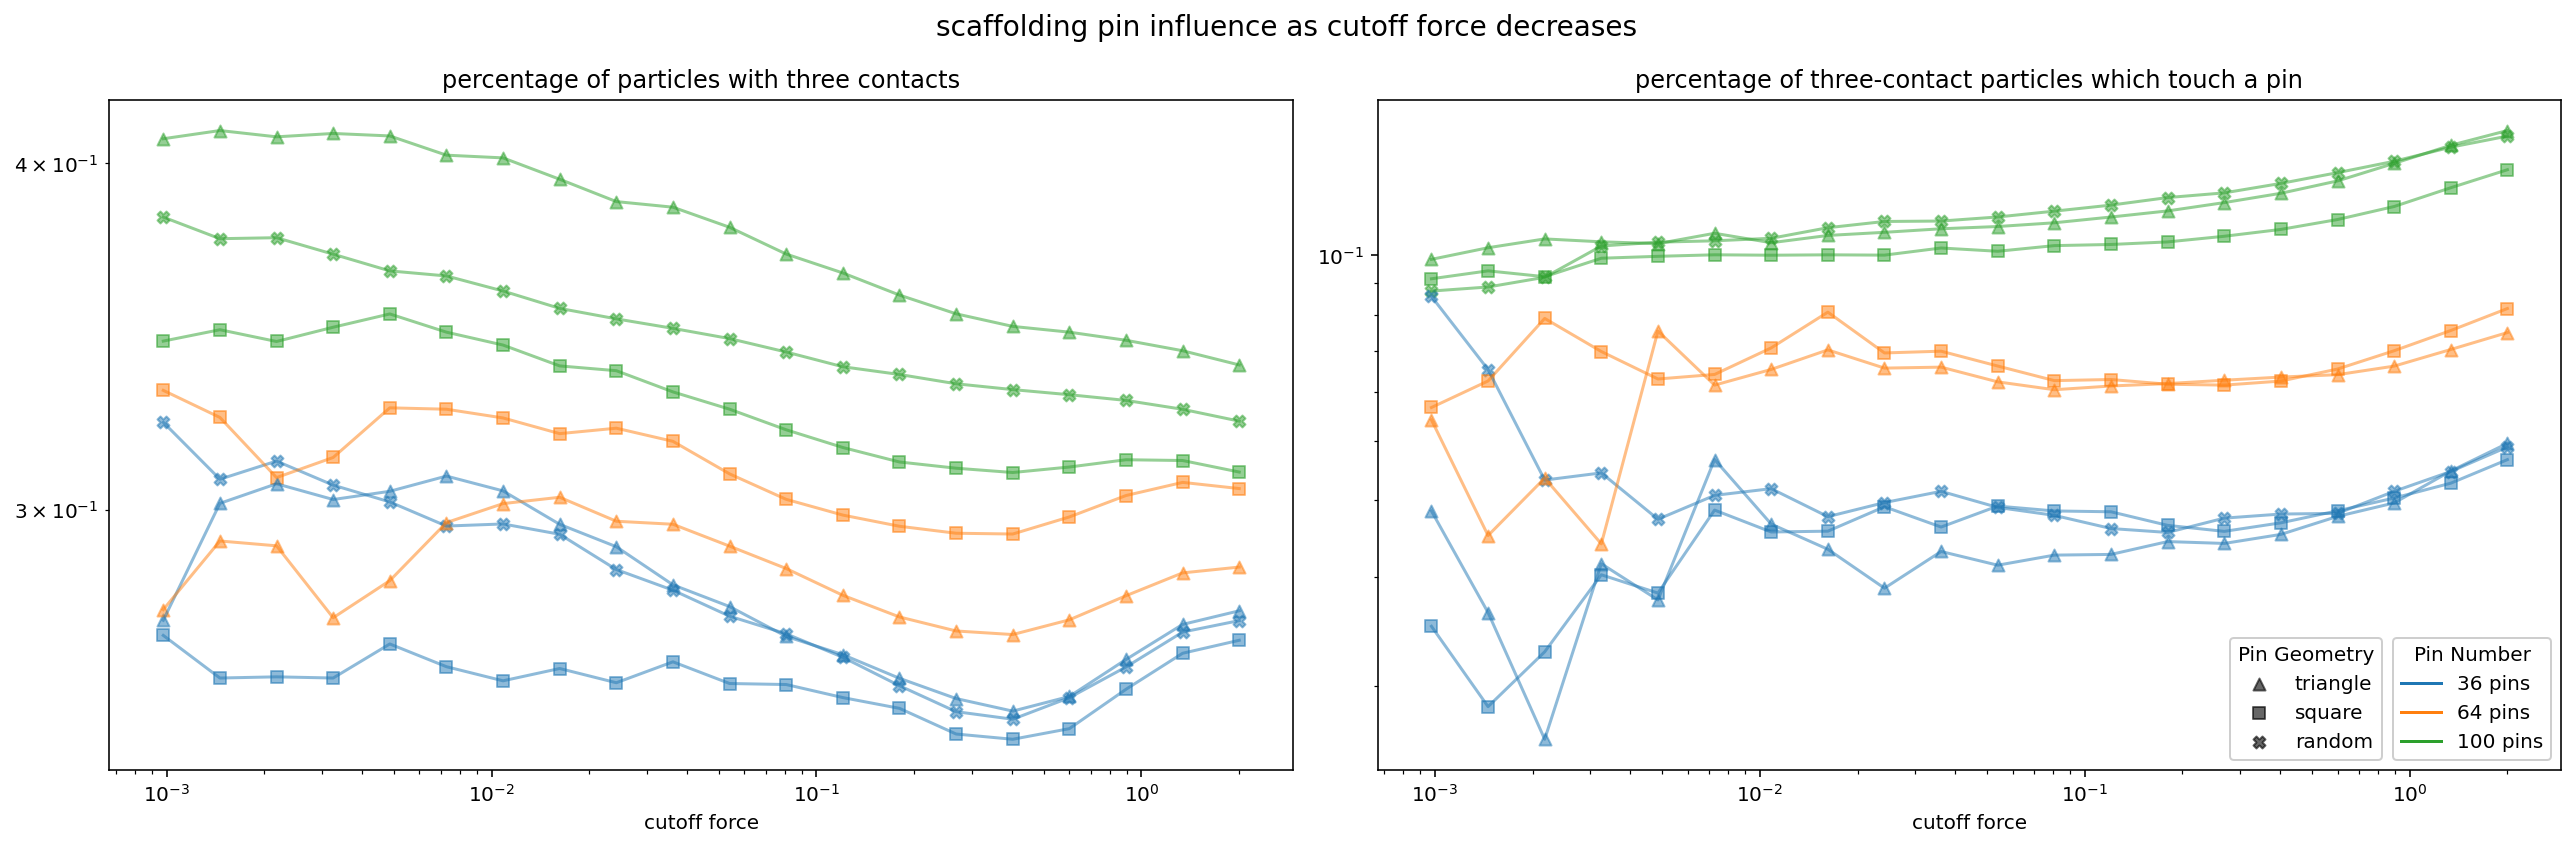

In [ ]:
fig, [axAll,axPins]=plt.subplots(1,2, figsize=(18,6))
for fileDF in threeBondDF.groupby('file'):
    if fileDF[0][0:3]=='squ':
        marker='s'
    elif fileDF[0][0:3]=='tri':
        marker='^'
    elif fileDF[0][0:3]=='ran':
        marker='X'
    if int(fileDF[0][3:5])==10:
        color='C2'
    elif int(fileDF[0][3:5])==36:
        color='C0'
    elif int(fileDF[0][3:5])==64:
        color='C1'
    axAll.scatter(fileDF[1].index.get_level_values(1),fileDF[1]['percentAll'], alpha=0.5, marker=marker, color=color)
    axAll.loglog(fileDF[1].index.get_level_values(1),fileDF[1]['percentAll'], color=color, alpha=0.5)
    axPins.scatter(fileDF[1].index.get_level_values(1),fileDF[1]['percentPins']/fileDF[1]['percentAll'], alpha=0.5, marker=marker, color=color)
    axPins.loglog(fileDF[1].index.get_level_values(1),fileDF[1]['percentPins']/fileDF[1]['percentAll'], color=color, alpha=0.5)
axAll.set_title('percentage of particles with three contacts')
axPins.set_title('percentage of three-contact particles which touch a pin')
axAll.set_xlabel('cutoff force')
axPins.set_xlabel('cutoff force')

plt.scatter([],[], marker='^',c='k', alpha = 0.6, label='triangle')
plt.scatter([],[], marker='s',c='k', alpha = 0.6, label = 'square')
plt.scatter([],[], marker='X',c='k', alpha = 0.6, label='random')

PinLegend1 = axPins.legend(loc=(0.72,0.015),title='Pin Geometry',framealpha=0.95)
axPins.add_artist(PinLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = axPins.legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='lower right',title='Pin Number',framealpha=0.95)

plt.xscale('log')
fig.suptitle('scaffolding pin influence as cutoff force decreases', fontsize=14)
fig.tight_layout()

#plt.savefig('plots/scaffolding_threebond_vs_cutoff-july2020.png', dpi=300)

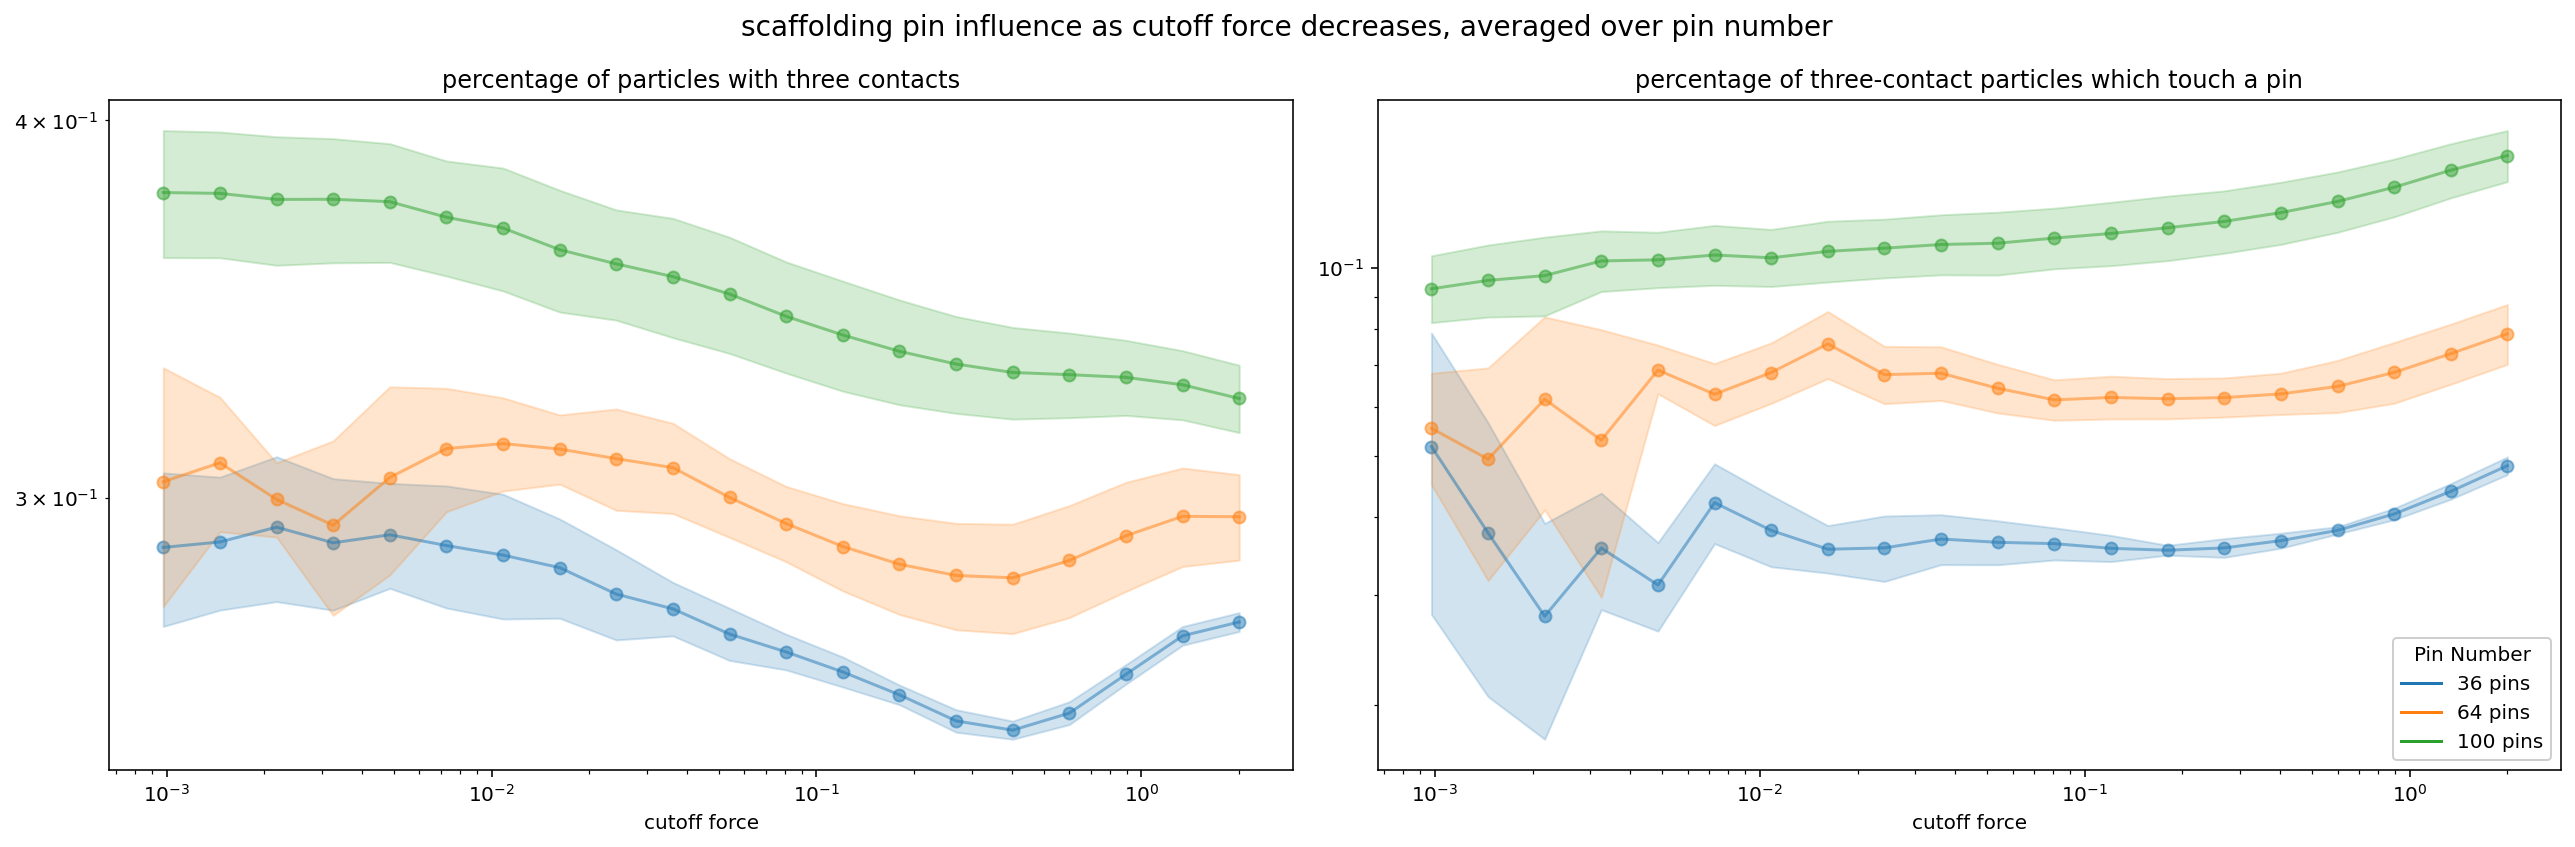

In [ ]:
fig, [axAll,axPins]=plt.subplots(1,2, figsize=(18,6))
pinGroups=[['tri36_07-11','squ36_07-11','ran36_07-11'],['tri64_07-12','squ64_07-12'],['tri100_07-19','squ100_07-19','ran100_07-19']]
for colorCounter, pinGroup in enumerate(pinGroups):
    avgDF=threeBondDF.loc[pinGroup].groupby('cutoff').agg(['mean','sem'])
    axAll.scatter(avgDF.index.values,avgDF['percentAll','mean'], alpha=0.5, color='C{}'.format(colorCounter))
    axAll.loglog(avgDF.index.values,avgDF['percentAll','mean'], color='C{}'.format(colorCounter), alpha=0.5)
    axAll.fill_between(avgDF.index.values,y1=avgDF['percentAll','mean']+avgDF['percentAll','sem'],y2=avgDF['percentAll','mean']-avgDF['percentAll','sem'], color='C{}'.format(colorCounter), alpha=0.2)
    axPins.scatter(avgDF.index.values,avgDF['percentPins','mean']/avgDF['percentAll','mean'], alpha=0.5, color='C{}'.format(colorCounter))
    axPins.loglog(avgDF.index.values,avgDF['percentPins','mean']/avgDF['percentAll','mean'], color='C{}'.format(colorCounter), alpha=0.5)
    axPins.fill_between(avgDF.index.values,y1=(avgDF['percentPins','mean']+avgDF['percentPins','sem'])/(avgDF['percentAll','mean']-avgDF['percentAll','sem']),y2=(avgDF['percentPins','mean']-avgDF['percentPins','sem'])/(avgDF['percentAll','mean']+avgDF['percentAll','sem']), color='C{}'.format(colorCounter), alpha=0.2)
axAll.set_title('percentage of particles with three contacts')
axPins.set_title('percentage of three-contact particles which touch a pin')
axAll.set_xlabel('cutoff force')
axPins.set_xlabel('cutoff force')
fig.suptitle('scaffolding pin influence as cutoff force decreases, averaged over pin number', fontsize=14)

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0'),
                Line2D([0], [0], color='C1'),
                Line2D([0], [0], color='C2'),]
lineLegend = axPins.legend(custom_lines1,['36 pins', '64 pins', '100 pins'],loc='lower right',title='Pin Number',framealpha=0.95)
fig.tight_layout()

#plt.savefig('plots/scaffolding_threebond_vs_cutoff_mean-july2020.png', dpi=300)

# 5. Visualizing individual trials

## 5.1. Topology Plotting Function
The plot_topography function takes a DataFrame and name of a trial and plots it. This primarily consists of preparing BondInfo data for plotting, which entails sorting particles by type, accounting for bonds which wrap at the boundary, and if the data is of a triangular lattice, applying a transformation before and after the other steps to make it compatible with our square lattice process.

This is necessary as our triangle lattice data is provided with rhombus rather than square boundaries, so we need to pivot the data $30^\circ$ to the left with respect to the x-axis to transform it into a square, account for wrapping, then pivot it back.

Note that pins are drawn disproportionately large for reference, and since we're only given the small particle radius, the large radius is found by scaling the small radius up by a factor of 1.4. If this relation varies, we will need more information.

In [0]:
plot_topography('non0_08-02',80, show=True, particles=True, pins=False, savefig='plots/presentation/jammed')

In [0]:
from matplotlib import collections
from matplotlib.lines import Line2D

# What's really important: picking a fun color scheme
#colormap = matplotlib.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'r', '#FFFFFF', '#FFFFFF']) # classic
colormap = matplotlib.cycler('color',['#FAD55C','#68C182','#267DB3','#ED6647','#8561C8','#000000', '#fef9e6', '#c0dff2']) # blue-yellow
plt.rc('axes',prop_cycle=colormap)

def plot_topography(file, trialName, savefig=False, title='Default', particles=True, pins=True, bonds=True, show=True, cutoff=None, sheared=True):
    # PARAMETERS:
    # file (str) - abbreviated file name, as specified list of files in first cell
    # trialName (str or int) - full trial name, e.g. 'ran-90440-266-36-0.02781-.16667', or integer index of a certain trial
    # savefig (bool/str) - If True, saves to plots folder. If string, saves to specified path.
    # title (str) - name for figure, if not default.
    # particles (bool) - whether or not to show particles.
    # pins (str) - if "all", attempts to extrapolate the entire pin lattice from existing pins. If False, pins are not shown. Otherwise, plots only contacted pins.
    # sheared (bool) - only significant for triangular lattices: if False, plots the data as a square instead ofa rhombus.
    # show (bool) - whether or not display the figure in output.
    # cutoff (float) - value at which to filter out forces. If positive, only show forces greater than the magnitude, and if negative, only show forces less than the magnitude.

    if isinstance(trialName,int):
        trialName=dataDict[file].index.get_level_values('trialName').unique()[trialName]

    bondInfo=dataDict[file].loc[trialName].copy() # get the data
    #find the mean force before filtering out bonds weaker than the cutoff
    meanForce=bondInfo.force.abs().mean()
    if cutoff:
        if cutoff>0:
            bondInfo=bondInfo[bondInfo.normalizedForce>=np.abs(cutoff)]
        elif cutoff<0:
            bondInfo=bondInfo[bondInfo.normalizedForce<=np.abs(cutoff)]

    bondInfo['bondColor']=bondInfo['bondType'].transform(lambda x: 'C'+str(x)) # takes bondtypes and transforms them into color codes

    headerNames=['geometry','seed','num','pins','small_radius','pin_separation']
    trialInfo={}
    for key, label in zip(headerNames,trialName.split('-')):
        trialInfo[key]=label

    # MAKING COORDINATE DATA USEFUL
    all_particles = sort_particles(bondInfo)[['x','y','particleType']].drop_duplicates() # get dataframe of particle coordinates sorted by bond type
    all_particles[['x','y']]=all_particles[['x','y']]*1e-6
    bondInfo[['x1','y1','x2','y2','normalizedForce']]=bondInfo[['x1','y1','x2','y2','normalizedForce']]*1e-6
    if trialInfo['geometry']=='tri': # extra steps for triangular lattice of pins
        # Un-shear the data, so that we can apply the same wrapping algorithm as in the square
        # unshearing matrix: [[1, -tan(30)],[0,1+tan(30)*tan(15)]] (in degrees)
        for x,y in [('x1','y1'),('x2','y2')]: # apply transformation to both sets of coordinate columns
            bondInfo[x]=bondInfo[x]-bondInfo[y]*np.tan(np.pi/6)
            bondInfo[y]=bondInfo[y]*(1+np.tan(np.pi/6)*np.tan(np.pi/12))

        if sheared==False: # normally we don't transform the particles at all, but if we want an unsheared plot we need to unshear the particles as well
            all_particles['x']-=all_particles['y']*np.tan(np.pi/6)
            all_particles['y']+=all_particles['y']*np.tan(np.pi/6)*np.tan(np.pi/12)

    # Find wrapping contacts - bonds that are too long not to be wrapping
    # (this is not memory efficient, but individual trials are small enough that we don't care)
    wrapsX=bondInfo[np.abs(bondInfo.x1-bondInfo.x2)>=0.5].copy() # 0.5 is kind of arbitrary here, all that matters is distance > (R_A+R_B)
    wrapsY=bondInfo[np.abs(bondInfo.y1-bondInfo.y2)>=0.5].copy()
    internalBonds=bondInfo.drop(pd.concat([wrapsX,wrapsY]).index.values) # dataframe of non-wrapped contacts

    # Wrapping algorithm: depending on which axis we're wrapping around, signs will flip - this value gives 1 or -1 for each wrapped contact according to sign convention
    wrapsY['yAdjust']=round(wrapsY['y1']-wrapsY['y2'])
    wrapsX['xAdjust']=round(wrapsX['x1']-wrapsX['x2'])

    # Additional case for when bonds wrap through three regions via corner
    wrapsCorner=pd.merge(wrapsX,wrapsY) # dataframe of contacts which wrap on X and Y, with both xAdjust and yAdjust included (corner cases have two sign conventions)
    cornerIndex=wrapsX.index.intersection(wrapsY.index) # TODO: probably a more optimal way to do this, since we're effectively checking for duplicates twice on this line and the previous.

    # Separate corner cases from edge cases (they'll plot differently)
    wrapsX=wrapsX.drop(cornerIndex)
    wrapsY=wrapsY.drop(cornerIndex)

    # Reformat data for LineCollection plotting - TODO: optimize
    # Internal lines
    sourcePoints=np.array([internalBonds['x1'],internalBonds['y1']]).T.reshape(-1,1,2)
    targetPoints=np.array([internalBonds['x2'],internalBonds['y2']]).T.reshape(-1,1,2)
    internalsegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # X-wrapped lines
    # don't love the repetitive .values calls here, but in 1- or 0- length cases this preserves the shape of the array
    sourcePoints=np.array([wrapsX['x1'].values-wrapsX['xAdjust'].values,wrapsX['y1'].values])
    targetPoints=np.array([wrapsX['x2'].values,wrapsX['y2'].values])
    sourcePoints=np.concatenate([sourcePoints,np.array([wrapsX['x1'].values,wrapsX['y1'].values])]).T.reshape(-1,1,2)
    targetPoints=np.concatenate([targetPoints,np.array([wrapsX['x2'].values+wrapsX['xAdjust'].values,wrapsX['y2'].values])]).T.reshape(-1,1,2)
    xsegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # Y-wrapped lines
    sourcePoints=np.array([wrapsY['x1'].values,wrapsY['y1'].values-wrapsY['yAdjust'].values])
    targetPoints=np.array([wrapsY['x2'].values,wrapsY['y2'].values])
    sourcePoints=np.concatenate([sourcePoints,np.array([wrapsY['x1'].values,wrapsY['y1'].values])]).T.reshape(-1,1,2)
    targetPoints=np.concatenate([targetPoints,np.array([wrapsY['x2'].values,wrapsY['y2'].values+wrapsY['yAdjust'].values])]).T.reshape(-1,1,2)
    ysegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    # Corner-wrapped lines
    sourcePoints=np.array([]).reshape(-1,1,2)
    targetPoints=np.array([]).reshape(-1,1,2)
    for i in [0,1]: # 2x2 loop (one run for each corner)
        for j in [0,1]:
            sourcePoints=np.concatenate([sourcePoints,np.array([wrapsCorner['x1'].values+wrapsCorner['xAdjust'].values*(i-1),
                                                                wrapsCorner['y1'].values+wrapsCorner['yAdjust'].values*(j-1)]).T.reshape(-1,1,2)])
            targetPoints=np.concatenate([targetPoints,np.array([wrapsCorner['x2'].values+wrapsCorner['xAdjust'].values*(i),
                                                                wrapsCorner['y2'].values+wrapsCorner['yAdjust'].values*(j)]).T.reshape(-1,1,2)])
    cornersegments=np.concatenate([sourcePoints,targetPoints],axis=1)

    if trialInfo['geometry']=='tri' and sheared==True:
        # re-shear the data
        # shearing matrix is [[1,sin(30)],[0,1-sin(30)*tan(15)]] (in degrees)
        for segmentgroup in [internalsegments,xsegments,ysegments,cornersegments]: # bad form to iterate like this, but like above the arrays are small enough to get away with it
            for segment in segmentgroup:
                for point in segment:
                    point[0]+=point[1]*np.sin(np.pi/6)
                    point[1]-=point[1]*np.sin(np.pi/6)*np.tan(np.pi/12)

    # Initialize patch collections
    # lines are plotted with thickness normalizedForce+1 to scale with bond strength while all being visible
    internalLines=collections.LineCollection(internalsegments,linewidths=internalBonds['normalizedForce']+1,color=internalBonds['bondColor'])
    xLines=collections.LineCollection(xsegments,linewidths=wrapsX['normalizedForce'].repeat(2)+1,color=wrapsX['bondColor'].repeat(2))
    yLines=collections.LineCollection(ysegments,linewidths=wrapsY['normalizedForce'].repeat(2),color=wrapsY['bondColor'].repeat(2))
    cornerLines=collections.LineCollection(cornersegments,linewidths=wrapsCorner['normalizedForce'].repeat(4),color=wrapsCorner['bondColor'].repeat(4))

    particleList=[]
    if particles:
        particleList+=[plt.Circle((x,y), radius=float(trialInfo['small_radius'])*1.4,ec='C5',fc='C7') for x,y in all_particles.loc[all_particles.particleType==2,['x','y']].values]
        particleList+=[plt.Circle((x,y), radius=float(trialInfo['small_radius']),ec='C5',fc='C6') for x,y in all_particles.loc[all_particles.particleType==1,['x','y']].values]
    if pins=='all' and trialInfo['geometry']!='ran':
        allPinsInFile=sort_particles(dataDict[file],types=[0])
        pinMin=allPinsInFile.min()*1e-6
        pinMax=allPinsInFile.max()*1e-6
        if trialInfo['geometry']=='tri':
            pinMin['x']-=pinMin['y']*np.tan(np.pi/6)
            pinMax['x']-=pinMax['y']*np.tan(np.pi/6)
        pinGrid=np.meshgrid(np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(int(trialInfo['pins'])))),np.linspace(pinMin['x'],pinMax['x'],int(np.sqrt(int(trialInfo['pins'])))))
        if trialInfo['geometry']=='tri' and sheared==True:
            pinGrid[0]+=pinGrid[1]*np.sin(np.pi/6)
            pinGrid[1]-=pinGrid[1]*np.sin(np.pi/6)*np.tan(np.pi/12)
        particleList+=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in np.vstack([pinGrid[0].flatten(),pinGrid[1].flatten()]).T]
    elif pins==True:
        particleList+=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in all_particles.loc[all_particles.particleType==0,['x','y']].values]

    ParticleCollection=collections.PatchCollection(particleList, match_original=True)

    plt.figure(figsize=(8,8)) # large, square plot
    a = plt.subplot() # initialize axes

    # Plot lines
    a.set(aspect='equal') # plot axes to scale
    if bonds:
        a.add_collection(internalLines)
        a.add_collection(xLines)
        a.add_collection(yLines)
        a.add_collection(cornerLines)

    # Plot particles
    a.add_collection(ParticleCollection)

    # Cosmetics
    if trialInfo['geometry']=='tri' and sheared==True: # for the rhombus, we need different axis limits
        a.set_xlim(0,1.5)
        a.set_ylim(-0.1,np.sqrt(3)/2+0.1)
        legendLocation='lower right'
    else:
        a.set_xlim(0,1)
        a.set_ylim(0,1)
        legendLocation='upper right'
    a.set_xlabel('x')
    a.set_ylabel('y')
    if title=='Default':
        a.set_title('Topography of {} data, {} total, seed {}, mean force={mf:.4f}'.format(file, *[trialInfo[x] for x in ['num','seed']], mf=meanForce))
    else:
        a.set_title(title)

    # Particle legend
    # can't directly label collections, so we designate shapes just for the legends
    a.scatter([],[],facecolors='C7',edgecolors='C5', s=150, label='large grains')
    a.scatter([],[],facecolors='C6',edgecolors='C5', s=100, label = 'small grains')
    a.scatter([],[],c='k', s=30,label='pins')

    particleLegend1 = a.legend(loc=legendLocation,title='Particle Types',framealpha=0.95)
    a.add_artist(particleLegend1) # matplotlib also overwrites with the latest legend call by default, so we specify we want this one as-is

    # Line legend
    custom_lines1 = [Line2D([0], [0], color='C0', lw=2),
                    Line2D([0], [0], color='C1', lw=2),
                    Line2D([0], [0], color='C2', lw=2),
                    Line2D([0], [0], color='C3', lw=2),
                    Line2D([0], [0], color='C4', lw=2)]
    lineLegend = a.legend(custom_lines1,['small-small','small-large','large-large','pin-small','pin-large'],loc='upper left',title='Contact Types',framealpha=0.95)

    if savefig:
        if isinstance(savefig,str):
            if not os.path.exists('/'.join(savefig.split('/')[:-1])):
                os.makedirs('/'.join(savefig.split('/')[:-1]))
            if cutoff:
                saveName = '{}-cutoff_{}.png'.format(savefig, np.abs(cutoff))
            else:
                saveName = '{}.png'.format(savefig)
        else:
            saveName = 'plots/{}.png'.format(trialName)
            print('Directory not specified, saving to plots folder')
        plt.savefig(saveName, dpi=300)
    if show:
        plt.show()
    plt.close()
    try:
        return saveName
    except:
        return trialName

In [0]:
for file in files:
    plot_topography(file, 0, pins='all', particles=False, sheared=False, savefig='plots/forAmy_allPins', show=True)

## 5.2. Animating Increasing Bond Strength Cutoff for a Trial/Identifying and Plotting Exceptionally Large Forces

In [0]:
import imageio
import os

for file in ['squ100_07-19']:
    print('FILE:', filenames[file])
    # Plotting exceptions
    for trialName in dataDict[file]['normalizedForce'].nlargest(10).index.get_level_values(0).unique():
        plot_topography(file, trialName, savefig='plots/exceptions', title='{} exception case, trial name {}'.format(file, trialName))

    # Creating Animations
    #for trialName in dataDict[file]['normalizedForce'].nlargest(10).index.get_level_values(0).unique():
    #    image_list=[]
    #    if not os.path.exists('Bond_Animations/'+trialName):
    #        os.makedirs('Bond_Animations/'+trialName)
    #    print('TRIAL:', trialName)
    #    for cutoffForce in [-100.0,-1.0,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1]:
    #        saveName=plot_topography(file, trialName, savefig='Bond_Animations/'+trialName, cutoff=cutoffForce, title='{} trial name {}, force cutoff {}'.format(file, trialName, np.abs(cutoffForce)))
    #        image_list.append(imageio.imread(saveName))
    #    imageio.mimwrite('Bond_Animations/{}/animated.gif'.format(trialName), image_list, duration = 2)

## 5.3. (Deprecated). Plotting lines directly in MatPlotLib
This code is fast, but plt.plot() can't account for varying line width; we end up using a LineCollection to do this in the next cell. Leaving this here for posterity.

In [ ]:
plt.figure(figsize=(8,8)) # large, square plot
# Plot internal bonds
plt.plot([internalBonds['x1'],internalBonds['x2']],[internalBonds['y1'],internalBonds['y2']],'C0')
# Plot bonds which wrap around boundary
plt.plot([wrapsY['x1'],wrapsY['x2']],[wrapsY['y1']-wrapsY['yAdjust'],wrapsY['y2']],'C3')
plt.plot([wrapsY['x1'],wrapsY['x2']],[wrapsY['y1'],wrapsY['y2']+wrapsY['yAdjust']],'C3')
plt.plot([wrapsX['x1']-wrapsX['xAdjust'],wrapsX['x2']],[wrapsX['y1'],wrapsX['y2']],'C1')
plt.plot([wrapsX['x1'],wrapsX['x2']+wrapsX['xAdjust']],[wrapsX['y1'],wrapsX['y2']],'C1')
# Change axis limits to size of simulation
plt.xlim(0,1)
plt.ylim(0,1)
#plt.savefig('plots/sampleNetwork.png',dpi=300)
plt.show()

## 5.4. (Deprecated). Plot with particleinfo.txt
A sample plotting of data from the last cell, with particles extrapolated from simulation_data/june_18/squ_BondInfo.txt, compared against a plot with particle types and locations explicitly given by a particleinfo.txt file. Note that with an additional file, we can pinpoint the location of rattlers and untouched pins.

In [ ]:
from matplotlib import collections
from matplotlib.lines import Line2D

internalLines=collections.LineCollection(internalsegments,linewidths=internalBonds['normalizedForce']+1,color=internalBonds['bondColor'])
xLines=collections.LineCollection(xsegments,linewidths=wrapsX['normalizedForce'].repeat(2)+1,color=wrapsX['bondColor'].repeat(2))
yLines=collections.LineCollection(ysegments,linewidths=wrapsY['normalizedForce'].repeat(2)+1,color=wrapsY['bondColor'].repeat(2))

largeParticles=[plt.Circle((x,y), radius=float(trialInfo['small_radius'])*1.4, color='r',fill=False) for x,y in large_mobile[['x','y']].values]
smallParticles=[plt.Circle((x,y), radius=float(trialInfo['small_radius']), color='r',fill=False) for x,y in small_mobile[['x','y']].values]
pinList=[plt.Circle((x,y), radius=0.005, color='k',fill=True) for x,y in pins[['x','y']].values]
bondParticleCollection=collections.PatchCollection(largeParticles+smallParticles+pinList, match_original=True)
#plt.figure(figsize=(16,8)) # large, square plot
fig, (ax1,ax2) = plt.subplots(1,2) # initialize axes

# Plot lines
ax1.set(aspect='equal')
ax1.add_collection(internalLines)
ax1.add_collection(xLines)
ax1.add_collection(yLines)

# Plot particles
ax1.add_collection(bondParticleCollection)

# Cosmetics
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Particle types reverse-engineered from bond types')
#Topology of 100 pin square lattice, 256 mobile, seed 80002
# Particle legend
# can't directly label collections, so we designate shapes julst for the legends
ax1.scatter([],[],facecolors='none',edgecolors='r', s=250, label='large grains')
ax1.scatter([],[],facecolors='none',edgecolors='r', s=100, label = 'small grains')
ax1.scatter([],[],c='k', s=30,label='pins')

particleLegend1 = ax1.legend(loc='upper right',title='Particle Types',framealpha=0.95)
ax1.add_artist(particleLegend1)

# Line legend
custom_lines1 = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='C1', lw=2),
                Line2D([0], [0], color='C2', lw=2),
                Line2D([0], [0], color='C3', lw=2),
                Line2D([0], [0], color='C4', lw=2)]
lineLegend = ax1.legend(custom_lines1,['small-small','small-large','large-large','pin-small','pin-large'],loc='upper left',title='Bond Types',framealpha=0.95)


# reading particleinfo file
particleInfo=pd.read_csv('simulation_data/june_18/particleInfo.txt', sep=' ', header=None, names=['particle_number', 'x', 'y', 'radius', 'is_rattler', 'is_pin_or_rattler'],usecols=[1,2,3,4,5])

# identify pin radius to distinguish from rattlers
pin_radius=particleInfo['radius'].min()

# Creating cosmetic columns
particleInfo['color']='r'
particleInfo['fill']=False
particleInfo['alpha']=1
particleInfo.loc[particleInfo.radius==pin_radius, ['color','fill','radius']] = 'k', True, 0.005
particleInfo.loc[particleInfo.is_rattler==1, ['color','fill','alpha']] = 'silver', True, 0.6

internalLines=collections.LineCollection(internalsegments,linewidths=internalBonds['normalizedForce']+1,color=internalBonds['bondColor'])
xLines=collections.LineCollection(xsegments,linewidths=wrapsX['normalizedForce'].repeat(2)+1,color=wrapsX['bondColor'].repeat(2))
yLines=collections.LineCollection(ysegments,linewidths=wrapsY['normalizedForce'].repeat(2)+1,color=wrapsY['bondColor'].repeat(2))

particleList=[plt.Circle((x,y), radius=r, color=color,fill=fill,alpha=alpha) for x,y,r,color,fill,alpha in particleInfo[['x','y','radius','color','fill','alpha']].values]
particles=collections.PatchCollection(particleList,match_original=True)

# Cosmetics
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Particle types given from particleinfo.txt')

ax2.set(aspect='equal')
ax2.add_collection(particles)
ax2.add_collection(internalLines)
ax2.add_collection(xLines)
ax2.add_collection(yLines)

# Particle legend
# can't directly label collections, so we designate shapes just for the legends
ax2.scatter([],[],facecolors='none',edgecolors='r', s=250, label='large grains')
ax2.scatter([],[],facecolors='none',edgecolors='r', s=100, label = 'small grains')
ax2.scatter([],[],facecolors='silver',edgecolors='silver',alpha=0.8, s=100, label = 'rattlers')
ax2.scatter([],[],c='k', s=30,label='pins')
particleLegend2 = ax2.legend(loc='upper right',title='Particle Types',framealpha=0.95)
ax2.add_artist(particleLegend2)

# Line legend
custom_lines2 = [Line2D([0], [0], color='C0', lw=2),
                Line2D([0], [0], color='C1', lw=2),
                Line2D([0], [0], color='C2', lw=2),
                Line2D([0], [0], color='C3', lw=2),
                Line2D([0], [0], color='C4', lw=2)]
lineLegend = ax2.legend(custom_lines2,['small-small','small-large','large-large','pin-small','pin-large'],loc='upper left',title='Bond Types',framealpha=0.95)
#plt.savefig('plots/topology_sourcefile_comparison.png',dpi=300)
plt.show()

## 5.5 (Deprecated). Plot contact force distribution as histogram for a single trial
Plots normalized contact forces $\frac{f}{\langle f\rangle}$ using seaborn's distplot() function. At this point, the y axis is not normalized; the kde parameter allows for normalization for a single data set, but to normalize the second plot collectively appears challenging.

In [ ]:
fig2 = plt.figure(figsize=(10,12))

hist1=fig2.add_subplot(2,1,1)
sns.distplot(bondInfo['normalizedForce'], hist=True, kde=False,
             bins=40, color = 'darkblue',
             hist_kws={'histtype':'step','linewidth':3,'alpha':0.95},
             #kde_kws={'linewidth': 0}
             )
hist1.set_xlim(-0.15,3.8)
hist1.set_title('force distribution of {} pin {} lattice, {} mobile, seed {}'.format(*[trialInfo[x] for x in ['pins','geometry','num','seed']]))
hist1.set_xlabel('')
#hist1.set_ylabel('probability density')

hist2=fig2.add_subplot(2,1,2)
bondInfo.groupby('bondType')['normalizedForce'].apply(lambda x: sns.distplot(x, hist=True, kde=False, bins=40, hist_kws={'histtype':'step','linewidth':3,'alpha':0.95}, label='bondType {}'.format(x.name)))
hist2.set_title('distribution by bond type')
hist2.set_xlabel('normalized contact forces')
hist2.set_xlim(-0.15,3.8)
hist2.legend()
#plt.savefig('plots/june_18_force_distribution_histogram.png', dpi=300)
plt.show()